# Analyze the solution landscape of networks partitioned with Infomap

In [25]:
# To install or upgrade to to the latest version of Infomap, see https://mapequation.github.io/infomap/
# pip install infomap / pip install --upgrade infomap
import sys
import infomap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from IPython.display import Image
from scipy.interpolate import griddata
# See:
# https://stackoverflow.com/questions/57242208/how-to-resolve-the-error-module-umap-has-no-attribute-umap-i-tried-installi
#import umap
import umap.umap_ as umap
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
sns.set(style="white")

#### Update to latest partition validation code (requires a gcc compiler)

In [2]:
%%bash
#Clone partition-validation repo if it does not exist, otherwhise pull. Then compile.
if [ ! -d "partition-validation" ] ; then
    git clone https://github.com/mapequation/partition-validation.git
else
    git -C partition-validation pull
fi
make -C partition-validation

g++ -std=c++11 -Wall -O3   -c -o partition-validation.o partition-validation.cc
g++ partition-validation.o -lm -o partition-validation


Cloning into 'partition-validation'...


#### Update infomap module

In [3]:
!pip install --upgrade infomap

You should consider upgrading via the '/opt/miniconda3/bin/python -m pip install --upgrade pip' command.


#### Find communities in the network

In [38]:
def findCommunities(networkName="pajek_influence_graph.net", seed=1):
    """
    Partition network with the Infomap algorithm.
    Annotates nodes with 'community' id.
    """

    im = infomap.Infomap(f"--directed -s {seed}")
    im.read_file(networkName)
    
    print(f"Find communities in {networkName} with Infomap...")
    im.run()

    print(f"Found {im.num_top_modules} top modules with codelength: {im.codelength}")
    communityDict = {node.node_id: ":".join(map(str, node.path[:-1]))
                    for node in im.nodes}
    
    return im.codelength, [path for _, path in sorted(communityDict.items())]

In [39]:
def printCommunities(networkName="pajek_influence_graph.net", seed=1, outfile="outfile.tree"):
    """
    Partition network with the Infomap algorithm.
    Print partition to .tree file
    """

    im = infomap.Infomap(f"--directed -s {seed}")
    im.read_file(networkName)
    
    print(f"Find communities in {networkName} with Infomap...")
    im.run()
    print(f"Found {im.num_top_modules} top modules with codelength: {im.codelength}")
    
    print(f"Writing results to {outfile}")
    im.write_tree(outfile)
    return im.codelength

# Analyze partition robustness

#### Definitions

<dl>
  <dt>Distance threshold</dt>
  <dd>The maximum weighted Jaccard distance between a cluster center and any other partition in the same cluster.</dd>    
    
  <dt>Validation score</dt>
  <dd>The fraction of validation partitions that fit into existing clusters.</dd>

  <dt>Validation set size</dt>
  <dd>The number of partitions hold out when measuring the validation score.</dd>       
    
  <dt>Accuracy</dt>
  <dd>The threshold validation score for a complete solution landscape.</dd>
</dl>

#### Partition clustering algorithm

1. Order all p network partitions from highest to lowest quality (from shortest to longest code length).
2. Let the highest quality network partition form cluster center 1.
3. Repeat until all network partitions have been clustered. Among the not yet clustered partitions, pick the one with the highest quality and assign it to the first of the m cluster centers that it is closer to than the distance threshold. If no such cluster center exists, let it form cluster center m + 1.

#### Solution landscape completeness algorithm

To determine the sufficient number of searches for a solution that is good enough given the distance threshold and solution landscape accuracy, we 

1. Run Infomap twice the validation set size and add the new partitions to previously identified partitions.
2. Randomly split all partitions into a validation set and a training set. Run the partition clustering algorithm on the training set and measure the validation score on the validation set. Resample a specified number of times for better estimate.
3. Repeat 1. and 2. until the validation score is higher than the specified accuracy.

#### Guidelines

In general, a solution landscape with a small distance threshold and a high accuracy requires many partitions. Moreover, networks with a flat solution landscape, characterized by relatively small differences in code length for distant solutions, require more partitions than networks with a peaked solutions landscape, characterized by relatively large difference in code length for similar solutions.

When exploring the solution landscape of a network, start with a relativelely large distance threshold, say 0.3, for fast results. If the alluvial diagram shows that the solutions vary more than desired, reduce the distance threshold and repeat the analysis. Continue this procedure until the solution landscape is complete for an acceptable distance threshold.

#### Networks

In [49]:
network = 'pajek_influence_graph.net' #  A network with a peaked solutions landscape, characterized by relatively large difference in code length for similar solutions.
accuracy = 0.9
distance_threshold = 0.29 # Requires 100 partitions

#network = 'data/email.net' # A network with a flat solution landscape, characterized by relatively small differences in code length for distant solutions.
#accuracy = 0.9
#distance_threshold = 0.3 # Requires 100 partitions
#distance_threshold = 0.25 # Requires > 2000 partitions

networkname = network.split("data/", 1)
networkname = networkname[len(networkname) - 1]

#### Find new solutions until complete solution landscape
Run as many searches as sufficient for a solution that is good enough given the distance threshold and solution landscape accuracy.

In [50]:
n_validation = 10
n_resamples = 100
currentValidationScore = 0.0
validation_data_df = pd.DataFrame(columns = ["n_validated","n_clusters","n_partitions","n_training","n_validation"])
partitions_df = pd.DataFrame()
niter = 5000

for i in range(niter):
    print(f"Iteration {i + 1}")
    codelength, communities = findCommunities(network, i)
    communities.insert(0, codelength)
    partitions_df = pd.concat([partitions_df, pd.DataFrame(communities, columns = [str(i)])], axis=1)
    
    if (i + 1) % (2 * n_validation) == 0:
        n_training = i + 1 - n_validation
        print(f"Running partition validation with {n_training} training partitions and {n_validation} validation partitions.")
        partitions_df.sort_values(by=0, axis=1, inplace=True)
        partitions_df.drop(0, axis=0, inplace=False).to_csv(r'results/partitions.csv', index=False, header=False, sep=' ')    
        !partition-validation/partition-validation -s 123 -t $distance_threshold --validation-sampling $n_training $n_validation $n_resamples results/partitions.csv results/partitions_clustering.txt
        validation_data_tmp_df = pd.read_csv('results/partitions_clustering_validation.txt', skiprows=1, header=None, delimiter=' ').rename(columns={0: "n_validated", 1: "n_clusters"})
        validation_data_tmp_df["n_partitions"] = i + 1
        validation_data_tmp_df["n_training"] = n_training
        validation_data_tmp_df["n_validation"] = n_validation
        currentValidationScore = validation_data_tmp_df['n_validated'].mean() / n_validation
        print(f"{100 * currentValidationScore}% of validation partitions fit in partition clusters from {n_training} training clusters.")
        validation_data_df = validation_data_df.append(validation_data_tmp_df, sort=False)
    if currentValidationScore > accuracy:
        break

Iteration 1
Find communities in pajek_influence_graph.net with Infomap...
Found 121 top modules with codelength: 7.947149363731823
Iteration 2
Find communities in pajek_influence_graph.net with Infomap...
Found 4 top modules with codelength: 7.926399480234484
Iteration 3
Find communities in pajek_influence_graph.net with Infomap...
Found 6 top modules with codelength: 7.925588916484565
Iteration 4
Find communities in pajek_influence_graph.net with Infomap...
Found 132 top modules with codelength: 7.960063475322945
Iteration 5
Find communities in pajek_influence_graph.net with Infomap...
Found 6 top modules with codelength: 7.924822371518757
Iteration 6
Find communities in pajek_influence_graph.net with Infomap...
Found 129 top modules with codelength: 7.956390861996887
Iteration 7
Find communities in pajek_influence_graph.net with Infomap...
Found 7 top modules with codelength: 7.935817324499819
Iteration 8
Find communities in pajek_influence_graph.net with Infomap...
Found 6 top modul

71.7% of validation partitions fit in partition clusters from 10 training clusters.
Iteration 21
Find communities in pajek_influence_graph.net with Infomap...
Found 4 top modules with codelength: 7.928010724254924
Iteration 22
Find communities in pajek_influence_graph.net with Infomap...
Found 126 top modules with codelength: 7.944021463974361
Iteration 23
Find communities in pajek_influence_graph.net with Infomap...
Found 127 top modules with codelength: 7.9256702919472275
Iteration 24
Find communities in pajek_influence_graph.net with Infomap...
Found 119 top modules with codelength: 7.945525550353574
Iteration 25
Find communities in pajek_influence_graph.net with Infomap...
Found 139 top modules with codelength: 7.947673988641651
Iteration 26
Find communities in pajek_influence_graph.net with Infomap...
Found 118 top modules with codelength: 7.953594234985104
Iteration 27
Find communities in pajek_influence_graph.net with Infomap...
Found 129 top modules with codelength: 7.969397100

-->Number of validation partitions out of 10 that fits in one of 14 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 93 samples: 0.72043
Clustering 30 partitions:
-->Number of validation partitions out of 10 that fits in one of 14 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 94 samples: 0.721277
Clustering 30 partitions:
-->Number of validation partitions out of 10 that fits in one of 14 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 95 samples: 0.722105
Clustering 30 partitions:
-->Number of validation partitions out of 10 that fits in one of 12 clusters is...6. 
-->Fraction of validation partitions that fits in a cluster after 96 samples: 0.720833
Clustering 30 partitions:
-->Number of validation partitions out of 10 that fits in one of 13 clusters is...7. 
-->Fraction of validation partitions that fits in a cluster after 97 samples: 0.720619
Clustering 30 partitions:
-->Num

-->Number of validation partitions out of 10 that fits in one of 20 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 26 samples: 0.726923
Clustering 50 partitions:
-->Number of validation partitions out of 10 that fits in one of 20 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 27 samples: 0.72963
Clustering 50 partitions:
-->Number of validation partitions out of 10 that fits in one of 21 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 28 samples: 0.735714
Clustering 50 partitions:
-->Number of validation partitions out of 10 that fits in one of 20 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 29 samples: 0.741379
Clustering 50 partitions:
-->Number of validation partitions out of 10 that fits in one of 20 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 30 samples: 0.743333
Clustering 50 partitions:
-->Num

76.2% of validation partitions fit in partition clusters from 50 training clusters.
Iteration 61
Find communities in pajek_influence_graph.net with Infomap...
Found 125 top modules with codelength: 7.949471962636533
Iteration 62
Find communities in pajek_influence_graph.net with Infomap...
Found 129 top modules with codelength: 7.979569572481376
Iteration 63
Find communities in pajek_influence_graph.net with Infomap...
Found 113 top modules with codelength: 7.930265883521863
Iteration 64
Find communities in pajek_influence_graph.net with Infomap...
Found 111 top modules with codelength: 7.934355536555453
Iteration 65
Find communities in pajek_influence_graph.net with Infomap...
Found 124 top modules with codelength: 7.949951454462291
Iteration 66
Find communities in pajek_influence_graph.net with Infomap...
Found 125 top modules with codelength: 7.919413232793967
Iteration 67
Find communities in pajek_influence_graph.net with Infomap...
Found 120 top modules with codelength: 7.94317429

-->Number of validation partitions out of 10 that fits in one of 23 clusters is...7. 
-->Fraction of validation partitions that fits in a cluster after 40 samples: 0.8175
Clustering 70 partitions:
-->Number of validation partitions out of 10 that fits in one of 23 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 41 samples: 0.817073
Clustering 70 partitions:
-->Number of validation partitions out of 10 that fits in one of 24 clusters is...7. 
-->Fraction of validation partitions that fits in a cluster after 42 samples: 0.814286
Clustering 70 partitions:
-->Number of validation partitions out of 10 that fits in one of 25 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 43 samples: 0.813953
Clustering 70 partitions:
-->Number of validation partitions out of 10 that fits in one of 25 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 44 samples: 0.818182
Clustering 70 partitions:
-->Num

80.60000000000001% of validation partitions fit in partition clusters from 70 training clusters.
Iteration 81
Find communities in pajek_influence_graph.net with Infomap...
Found 5 top modules with codelength: 7.935137367257139
Iteration 82
Find communities in pajek_influence_graph.net with Infomap...
Found 123 top modules with codelength: 7.940249343661581
Iteration 83
Find communities in pajek_influence_graph.net with Infomap...
Found 120 top modules with codelength: 7.9425691354044385
Iteration 84
Find communities in pajek_influence_graph.net with Infomap...
Found 121 top modules with codelength: 7.938356571105531
Iteration 85
Find communities in pajek_influence_graph.net with Infomap...
Found 4 top modules with codelength: 7.915358271822784
Iteration 86
Find communities in pajek_influence_graph.net with Infomap...
Found 114 top modules with codelength: 7.930469649383619
Iteration 87
Find communities in pajek_influence_graph.net with Infomap...
Found 6 top modules with codelength: 7.

-->Number of validation partitions out of 10 that fits in one of 25 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 33 samples: 0.80303
Clustering 90 partitions:
-->Number of validation partitions out of 10 that fits in one of 26 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 34 samples: 0.802941
Clustering 90 partitions:
-->Number of validation partitions out of 10 that fits in one of 27 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 35 samples: 0.805714
Clustering 90 partitions:
-->Number of validation partitions out of 10 that fits in one of 25 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 36 samples: 0.805556
Clustering 90 partitions:
-->Number of validation partitions out of 10 that fits in one of 25 clusters is...7. 
-->Fraction of validation partitions that fits in a cluster after 37 samples: 0.802703
Clustering 90 partitions:
-->Num

80.5% of validation partitions fit in partition clusters from 90 training clusters.
Iteration 101
Find communities in pajek_influence_graph.net with Infomap...
Found 5 top modules with codelength: 7.941263209527397
Iteration 102
Find communities in pajek_influence_graph.net with Infomap...
Found 121 top modules with codelength: 7.938678417811255
Iteration 103
Find communities in pajek_influence_graph.net with Infomap...
Found 5 top modules with codelength: 7.954543936112845
Iteration 104
Find communities in pajek_influence_graph.net with Infomap...
Found 127 top modules with codelength: 7.926787131668833
Iteration 105
Find communities in pajek_influence_graph.net with Infomap...
Found 5 top modules with codelength: 7.917165371746484
Iteration 106
Find communities in pajek_influence_graph.net with Infomap...
Found 125 top modules with codelength: 7.955098893123695
Iteration 107
Find communities in pajek_influence_graph.net with Infomap...
Found 115 top modules with codelength: 7.9315593

-->Number of validation partitions out of 10 that fits in one of 32 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 26 samples: 0.811538
Clustering 110 partitions:
-->Number of validation partitions out of 10 that fits in one of 26 clusters is...7. 
-->Fraction of validation partitions that fits in a cluster after 27 samples: 0.807407
Clustering 110 partitions:
-->Number of validation partitions out of 10 that fits in one of 33 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 28 samples: 0.814286
Clustering 110 partitions:
-->Number of validation partitions out of 10 that fits in one of 28 clusters is...5. 
-->Fraction of validation partitions that fits in a cluster after 29 samples: 0.803448
Clustering 110 partitions:
-->Number of validation partitions out of 10 that fits in one of 32 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 30 samples: 0.806667
Clustering 110 partitions:

80.3% of validation partitions fit in partition clusters from 110 training clusters.
Iteration 121
Find communities in pajek_influence_graph.net with Infomap...
Found 130 top modules with codelength: 7.935714819808041
Iteration 122
Find communities in pajek_influence_graph.net with Infomap...
Found 5 top modules with codelength: 7.931860035298754
Iteration 123
Find communities in pajek_influence_graph.net with Infomap...
Found 122 top modules with codelength: 7.934683729490506
Iteration 124
Find communities in pajek_influence_graph.net with Infomap...
Found 121 top modules with codelength: 7.936235315203553
Iteration 125
Find communities in pajek_influence_graph.net with Infomap...
Found 118 top modules with codelength: 7.952630565598723
Iteration 126
Find communities in pajek_influence_graph.net with Infomap...
Found 5 top modules with codelength: 7.9498897658308705
Iteration 127
Find communities in pajek_influence_graph.net with Infomap...
Found 117 top modules with codelength: 7.958

-->Number of validation partitions out of 10 that fits in one of 37 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 31 samples: 0.880645
Clustering 130 partitions:
-->Number of validation partitions out of 10 that fits in one of 35 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 32 samples: 0.884375
Clustering 130 partitions:
-->Number of validation partitions out of 10 that fits in one of 32 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 33 samples: 0.881818
Clustering 130 partitions:
-->Number of validation partitions out of 10 that fits in one of 34 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 34 samples: 0.882353
Clustering 130 partitions:
-->Number of validation partitions out of 10 that fits in one of 35 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 35 samples: 0.885714
Clustering 130 partitions

-->Number of validation partitions out of 10 that fits in one of 32 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 82 samples: 0.853659
Clustering 130 partitions:
-->Number of validation partitions out of 10 that fits in one of 33 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 83 samples: 0.855422
Clustering 130 partitions:
-->Number of validation partitions out of 10 that fits in one of 30 clusters is...7. 
-->Fraction of validation partitions that fits in a cluster after 84 samples: 0.853571
Clustering 130 partitions:
-->Number of validation partitions out of 10 that fits in one of 33 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 85 samples: 0.852941
Clustering 130 partitions:
-->Number of validation partitions out of 10 that fits in one of 34 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 86 samples: 0.853488
Clustering 130 partitions:

-->Number of validation partitions out of 10 that fits in one of 37 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 7 samples: 0.928571
Clustering 150 partitions:
-->Number of validation partitions out of 10 that fits in one of 36 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 8 samples: 0.925
Clustering 150 partitions:
-->Number of validation partitions out of 10 that fits in one of 37 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 9 samples: 0.922222
Clustering 150 partitions:
-->Number of validation partitions out of 10 that fits in one of 37 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 10 samples: 0.93
Clustering 150 partitions:
-->Number of validation partitions out of 10 that fits in one of 36 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 11 samples: 0.927273
Clustering 150 partitions:
-->Numbe

-->Number of validation partitions out of 10 that fits in one of 38 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 50 samples: 0.858
Clustering 150 partitions:
-->Number of validation partitions out of 10 that fits in one of 37 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 51 samples: 0.860784
Clustering 150 partitions:
-->Number of validation partitions out of 10 that fits in one of 37 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 52 samples: 0.861538
Clustering 150 partitions:
-->Number of validation partitions out of 10 that fits in one of 36 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 53 samples: 0.862264
Clustering 150 partitions:
-->Number of validation partitions out of 10 that fits in one of 36 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 54 samples: 0.862963
Clustering 150 partitions:
--

84.5% of validation partitions fit in partition clusters from 150 training clusters.
Iteration 161
Find communities in pajek_influence_graph.net with Infomap...
Found 122 top modules with codelength: 7.960904308908122
Iteration 162
Find communities in pajek_influence_graph.net with Infomap...
Found 119 top modules with codelength: 7.916899120330915
Iteration 163
Find communities in pajek_influence_graph.net with Infomap...
Found 120 top modules with codelength: 7.948300167419141
Iteration 164
Find communities in pajek_influence_graph.net with Infomap...
Found 118 top modules with codelength: 7.924754591749316
Iteration 165
Find communities in pajek_influence_graph.net with Infomap...
Found 119 top modules with codelength: 7.960387819328898
Iteration 166
Find communities in pajek_influence_graph.net with Infomap...
Found 128 top modules with codelength: 7.948247414516648
Iteration 167
Find communities in pajek_influence_graph.net with Infomap...
Found 6 top modules with codelength: 7.94

-->Number of validation partitions out of 10 that fits in one of 43 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 28 samples: 0.832143
Clustering 170 partitions:
-->Number of validation partitions out of 10 that fits in one of 37 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 29 samples: 0.831034
Clustering 170 partitions:
-->Number of validation partitions out of 10 that fits in one of 42 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 30 samples: 0.836667
Clustering 170 partitions:
-->Number of validation partitions out of 10 that fits in one of 37 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 31 samples: 0.835484
Clustering 170 partitions:
-->Number of validation partitions out of 10 that fits in one of 35 clusters is...5. 
-->Fraction of validation partitions that fits in a cluster after 32 samples: 0.825
Clustering 170 partitions:
-

-->Number of validation partitions out of 10 that fits in one of 42 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 79 samples: 0.843038
Clustering 170 partitions:
-->Number of validation partitions out of 10 that fits in one of 38 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 80 samples: 0.84375
Clustering 170 partitions:
-->Number of validation partitions out of 10 that fits in one of 38 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 81 samples: 0.84321
Clustering 170 partitions:
-->Number of validation partitions out of 10 that fits in one of 39 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 82 samples: 0.843902
Clustering 170 partitions:
-->Number of validation partitions out of 10 that fits in one of 36 clusters is...7. 
-->Fraction of validation partitions that fits in a cluster after 83 samples: 0.842169
Clustering 170 partitions:
--

-->Number of validation partitions out of 10 that fits in one of 38 clusters is...6. 
-->Fraction of validation partitions that fits in a cluster after 3 samples: 0.766667
Clustering 190 partitions:
-->Number of validation partitions out of 10 that fits in one of 43 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 4 samples: 0.8
Clustering 190 partitions:
-->Number of validation partitions out of 10 that fits in one of 40 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 5 samples: 0.8
Clustering 190 partitions:
-->Number of validation partitions out of 10 that fits in one of 42 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 6 samples: 0.816667
Clustering 190 partitions:
-->Number of validation partitions out of 10 that fits in one of 42 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 7 samples: 0.828571
Clustering 190 partitions:
-->Number of va

-->Number of validation partitions out of 10 that fits in one of 43 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 45 samples: 0.868889
Clustering 190 partitions:
-->Number of validation partitions out of 10 that fits in one of 40 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 46 samples: 0.867391
Clustering 190 partitions:
-->Number of validation partitions out of 10 that fits in one of 42 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 47 samples: 0.870213
Clustering 190 partitions:
-->Number of validation partitions out of 10 that fits in one of 42 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 48 samples: 0.872917
Clustering 190 partitions:
-->Number of validation partitions out of 10 that fits in one of 41 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 49 samples: 0.873469
Clustering 190 partitions

-->Number of validation partitions out of 10 that fits in one of 40 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 89 samples: 0.857303
Clustering 190 partitions:
-->Number of validation partitions out of 10 that fits in one of 40 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 90 samples: 0.856667
Clustering 190 partitions:
-->Number of validation partitions out of 10 that fits in one of 43 clusters is...6. 
-->Fraction of validation partitions that fits in a cluster after 91 samples: 0.853846
Clustering 190 partitions:
-->Number of validation partitions out of 10 that fits in one of 39 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 92 samples: 0.853261
Clustering 190 partitions:
-->Number of validation partitions out of 10 that fits in one of 41 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 93 samples: 0.853763
Clustering 190 partitions:


-->Number of validation partitions out of 10 that fits in one of 47 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 13 samples: 0.830769
Clustering 210 partitions:
-->Number of validation partitions out of 10 that fits in one of 47 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 14 samples: 0.828571
Clustering 210 partitions:
-->Number of validation partitions out of 10 that fits in one of 42 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 15 samples: 0.826667
Clustering 210 partitions:
-->Number of validation partitions out of 10 that fits in one of 44 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 16 samples: 0.8375
Clustering 210 partitions:
-->Number of validation partitions out of 10 that fits in one of 44 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 17 samples: 0.847059
Clustering 210 partitions:


-->Number of validation partitions out of 10 that fits in one of 45 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 56 samples: 0.832143
Clustering 210 partitions:
-->Number of validation partitions out of 10 that fits in one of 44 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 57 samples: 0.835088
Clustering 210 partitions:
-->Number of validation partitions out of 10 that fits in one of 42 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 58 samples: 0.834483
Clustering 210 partitions:
-->Number of validation partitions out of 10 that fits in one of 43 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 59 samples: 0.835593
Clustering 210 partitions:
-->Number of validation partitions out of 10 that fits in one of 41 clusters is...7. 
-->Fraction of validation partitions that fits in a cluster after 60 samples: 0.833333
Clustering 210 partitions:

83.7% of validation partitions fit in partition clusters from 210 training clusters.
Iteration 221
Find communities in pajek_influence_graph.net with Infomap...
Found 121 top modules with codelength: 7.943246300665309
Iteration 222
Find communities in pajek_influence_graph.net with Infomap...
Found 118 top modules with codelength: 7.921022030295343
Iteration 223
Find communities in pajek_influence_graph.net with Infomap...
Found 129 top modules with codelength: 7.944651380751246
Iteration 224
Find communities in pajek_influence_graph.net with Infomap...
Found 126 top modules with codelength: 7.9330911859639865
Iteration 225
Find communities in pajek_influence_graph.net with Infomap...
Found 133 top modules with codelength: 7.961019685929046
Iteration 226
Find communities in pajek_influence_graph.net with Infomap...
Found 124 top modules with codelength: 7.951091321223635
Iteration 227
Find communities in pajek_influence_graph.net with Infomap...
Found 119 top modules with codelength: 7

-->Number of validation partitions out of 10 that fits in one of 44 clusters is...7. 
-->Fraction of validation partitions that fits in a cluster after 26 samples: 0.876923
Clustering 230 partitions:
-->Number of validation partitions out of 10 that fits in one of 47 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 27 samples: 0.881481
Clustering 230 partitions:
-->Number of validation partitions out of 10 that fits in one of 46 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 28 samples: 0.882143
Clustering 230 partitions:
-->Number of validation partitions out of 10 that fits in one of 47 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 29 samples: 0.886207
Clustering 230 partitions:
-->Number of validation partitions out of 10 that fits in one of 45 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 30 samples: 0.883333
Clustering 230 partitions

-->Number of validation partitions out of 10 that fits in one of 45 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 68 samples: 0.879412
Clustering 230 partitions:
-->Number of validation partitions out of 10 that fits in one of 47 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 69 samples: 0.881159
Clustering 230 partitions:
-->Number of validation partitions out of 10 that fits in one of 45 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 70 samples: 0.88
Clustering 230 partitions:
-->Number of validation partitions out of 10 that fits in one of 46 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 71 samples: 0.880282
Clustering 230 partitions:
-->Number of validation partitions out of 10 that fits in one of 45 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 72 samples: 0.879167
Clustering 230 partitions:
-->

Iteration 253
Find communities in pajek_influence_graph.net with Infomap...
Found 129 top modules with codelength: 7.958099907312705
Iteration 254
Find communities in pajek_influence_graph.net with Infomap...
Found 116 top modules with codelength: 7.974707157240609
Iteration 255
Find communities in pajek_influence_graph.net with Infomap...
Found 130 top modules with codelength: 7.947902836497824
Iteration 256
Find communities in pajek_influence_graph.net with Infomap...
Found 110 top modules with codelength: 7.943723701849273
Iteration 257
Find communities in pajek_influence_graph.net with Infomap...
Found 113 top modules with codelength: 7.9266043321784485
Iteration 258
Find communities in pajek_influence_graph.net with Infomap...
Found 118 top modules with codelength: 7.972974431579856
Iteration 259
Find communities in pajek_influence_graph.net with Infomap...
Found 118 top modules with codelength: 7.93135771795767
Iteration 260
Find communities in pajek_influence_graph.net with Info

-->Number of validation partitions out of 10 that fits in one of 51 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 38 samples: 0.860526
Clustering 250 partitions:
-->Number of validation partitions out of 10 that fits in one of 52 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 39 samples: 0.861538
Clustering 250 partitions:
-->Number of validation partitions out of 10 that fits in one of 52 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 40 samples: 0.865
Clustering 250 partitions:
-->Number of validation partitions out of 10 that fits in one of 49 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 41 samples: 0.863415
Clustering 250 partitions:
-->Number of validation partitions out of 10 that fits in one of 51 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 42 samples: 0.864286
Clustering 250 partitions:
--

86.1% of validation partitions fit in partition clusters from 250 training clusters.
Iteration 261
Find communities in pajek_influence_graph.net with Infomap...
Found 122 top modules with codelength: 7.9485022312105205
Iteration 262
Find communities in pajek_influence_graph.net with Infomap...
Found 5 top modules with codelength: 7.9200167181863055
Iteration 263
Find communities in pajek_influence_graph.net with Infomap...
Found 117 top modules with codelength: 7.927652103656412
Iteration 264
Find communities in pajek_influence_graph.net with Infomap...
Found 121 top modules with codelength: 7.917296359463375
Iteration 265
Find communities in pajek_influence_graph.net with Infomap...
Found 112 top modules with codelength: 7.93089665862209
Iteration 266
Find communities in pajek_influence_graph.net with Infomap...
Found 7 top modules with codelength: 7.960508471425115
Iteration 267
Find communities in pajek_influence_graph.net with Infomap...
Found 122 top modules with codelength: 7.927

-->Number of validation partitions out of 10 that fits in one of 54 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 34 samples: 0.838235
Clustering 270 partitions:
-->Number of validation partitions out of 10 that fits in one of 55 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 35 samples: 0.84
Clustering 270 partitions:
-->Number of validation partitions out of 10 that fits in one of 54 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 36 samples: 0.838889
Clustering 270 partitions:
-->Number of validation partitions out of 10 that fits in one of 54 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 37 samples: 0.837838
Clustering 270 partitions:
-->Number of validation partitions out of 10 that fits in one of 54 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 38 samples: 0.839474
Clustering 270 partitions:
-->N

-->Number of validation partitions out of 10 that fits in one of 58 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 76 samples: 0.853947
Clustering 270 partitions:
-->Number of validation partitions out of 10 that fits in one of 55 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 77 samples: 0.854545
Clustering 270 partitions:
-->Number of validation partitions out of 10 that fits in one of 55 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 78 samples: 0.855128
Clustering 270 partitions:
-->Number of validation partitions out of 10 that fits in one of 55 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 79 samples: 0.855696
Clustering 270 partitions:
-->Number of validation partitions out of 10 that fits in one of 54 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 80 samples: 0.855
Clustering 270 partitions:
-->

Reading partitions file with 300 partitions...of 5603 nodes...done!
Clustering 290 partitions:
-->Number of validation partitions out of 10 that fits in one of 60 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 1 samples: 1
Clustering 290 partitions:
-->Number of validation partitions out of 10 that fits in one of 59 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 2 samples: 1
Clustering 290 partitions:
-->Number of validation partitions out of 10 that fits in one of 57 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 3 samples: 0.966667
Clustering 290 partitions:
-->Number of validation partitions out of 10 that fits in one of 59 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 4 samples: 0.95
Clustering 290 partitions:
-->Number of validation partitions out of 10 that fits in one of 58 clusters is...9. 
-->Fraction of validation partitions th

-->Number of validation partitions out of 10 that fits in one of 56 clusters is...7. 
-->Fraction of validation partitions that fits in a cluster after 43 samples: 0.881395
Clustering 290 partitions:
-->Number of validation partitions out of 10 that fits in one of 58 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 44 samples: 0.881818
Clustering 290 partitions:
-->Number of validation partitions out of 10 that fits in one of 58 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 45 samples: 0.884444
Clustering 290 partitions:
-->Number of validation partitions out of 10 that fits in one of 58 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 46 samples: 0.884783
Clustering 290 partitions:
-->Number of validation partitions out of 10 that fits in one of 58 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 47 samples: 0.885106
Clustering 290 partitions:

87.20000000000002% of validation partitions fit in partition clusters from 290 training clusters.
Iteration 301
Find communities in pajek_influence_graph.net with Infomap...
Found 120 top modules with codelength: 7.931811351544992
Iteration 302
Find communities in pajek_influence_graph.net with Infomap...
Found 114 top modules with codelength: 7.9186541280523475
Iteration 303
Find communities in pajek_influence_graph.net with Infomap...
Found 111 top modules with codelength: 7.93456981921826
Iteration 304
Find communities in pajek_influence_graph.net with Infomap...
Found 129 top modules with codelength: 7.94399078758118
Iteration 305
Find communities in pajek_influence_graph.net with Infomap...
Found 134 top modules with codelength: 7.938938016841197
Iteration 306
Find communities in pajek_influence_graph.net with Infomap...
Found 124 top modules with codelength: 7.935210487925875
Iteration 307
Find communities in pajek_influence_graph.net with Infomap...
Found 123 top modules with co

-->Number of validation partitions out of 10 that fits in one of 60 clusters is...7. 
-->Fraction of validation partitions that fits in a cluster after 25 samples: 0.88
Clustering 310 partitions:
-->Number of validation partitions out of 10 that fits in one of 63 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 26 samples: 0.884615
Clustering 310 partitions:
-->Number of validation partitions out of 10 that fits in one of 61 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 27 samples: 0.885185
Clustering 310 partitions:
-->Number of validation partitions out of 10 that fits in one of 65 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 28 samples: 0.885714
Clustering 310 partitions:
-->Number of validation partitions out of 10 that fits in one of 61 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 29 samples: 0.882759
Clustering 310 partitions:
-->

-->Number of validation partitions out of 10 that fits in one of 58 clusters is...6. 
-->Fraction of validation partitions that fits in a cluster after 73 samples: 0.860274
Clustering 310 partitions:
-->Number of validation partitions out of 10 that fits in one of 66 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 74 samples: 0.862162
Clustering 310 partitions:
-->Number of validation partitions out of 10 that fits in one of 63 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 75 samples: 0.864
Clustering 310 partitions:
-->Number of validation partitions out of 10 that fits in one of 61 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 76 samples: 0.863158
Clustering 310 partitions:
-->Number of validation partitions out of 10 that fits in one of 62 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 77 samples: 0.863636
Clustering 310 partitions:
-

Found 119 top modules with codelength: 7.941591854894433
Running partition validation with 330 training partitions and 10 validation partitions.
Version: March 5, 2020.
Command: partition-validation/partition-validation -s 123 -t 0.29 --validation-sampling 330 10 100 results/partitions.csv results/partitions_clustering.txt
Setup:
-->Using seed: 123
-->Will cluster partitions such that no partition is farther away from its center than: 0.29
-->Will read partitions from file: results/partitions.csv
-->Will perform validation sampling of 10 partitions given 330 training partitions 100 times.
-->Will write clusters to file: results/partitions_clustering.txt
-->Will use number of threads: 1
Reading partitions file with 340 partitions...of 5603 nodes...done!
Clustering 330 partitions:
-->Number of validation partitions out of 10 that fits in one of 65 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 1 samples: 1
Clustering 330 partitions:
-->Number of vali

-->Number of validation partitions out of 10 that fits in one of 65 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 39 samples: 0.876923
Clustering 330 partitions:
-->Number of validation partitions out of 10 that fits in one of 66 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 40 samples: 0.88
Clustering 330 partitions:
-->Number of validation partitions out of 10 that fits in one of 63 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 41 samples: 0.878049
Clustering 330 partitions:
-->Number of validation partitions out of 10 that fits in one of 64 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 42 samples: 0.87619
Clustering 330 partitions:
-->Number of validation partitions out of 10 that fits in one of 67 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 43 samples: 0.874419
Clustering 330 partitions:
-->

-->Number of validation partitions out of 10 that fits in one of 67 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 82 samples: 0.867073
Clustering 330 partitions:
-->Number of validation partitions out of 10 that fits in one of 66 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 83 samples: 0.868675
Clustering 330 partitions:
-->Number of validation partitions out of 10 that fits in one of 66 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 84 samples: 0.870238
Clustering 330 partitions:
-->Number of validation partitions out of 10 that fits in one of 65 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 85 samples: 0.870588
Clustering 330 partitions:
-->Number of validation partitions out of 10 that fits in one of 65 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 86 samples: 0.87093
Clustering 330 partitions:

-->Number of validation partitions out of 10 that fits in one of 68 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 7 samples: 0.842857
Clustering 350 partitions:
-->Number of validation partitions out of 10 that fits in one of 70 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 8 samples: 0.85
Clustering 350 partitions:
-->Number of validation partitions out of 10 that fits in one of 68 clusters is...7. 
-->Fraction of validation partitions that fits in a cluster after 9 samples: 0.833333
Clustering 350 partitions:
-->Number of validation partitions out of 10 that fits in one of 68 clusters is...7. 
-->Fraction of validation partitions that fits in a cluster after 10 samples: 0.82
Clustering 350 partitions:
-->Number of validation partitions out of 10 that fits in one of 70 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 11 samples: 0.827273
Clustering 350 partitions:
-->Number o

-->Number of validation partitions out of 10 that fits in one of 69 clusters is...7. 
-->Fraction of validation partitions that fits in a cluster after 52 samples: 0.840385
Clustering 350 partitions:
-->Number of validation partitions out of 10 that fits in one of 68 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 53 samples: 0.839623
Clustering 350 partitions:
-->Number of validation partitions out of 10 that fits in one of 68 clusters is...7. 
-->Fraction of validation partitions that fits in a cluster after 54 samples: 0.837037
Clustering 350 partitions:
-->Number of validation partitions out of 10 that fits in one of 70 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 55 samples: 0.84
Clustering 350 partitions:
-->Number of validation partitions out of 10 that fits in one of 71 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 56 samples: 0.842857
Clustering 350 partitions:
--

84.89999999999999% of validation partitions fit in partition clusters from 350 training clusters.
Iteration 361
Find communities in pajek_influence_graph.net with Infomap...
Found 128 top modules with codelength: 7.930335848835403
Iteration 362
Find communities in pajek_influence_graph.net with Infomap...
Found 113 top modules with codelength: 7.950912369016369
Iteration 363
Find communities in pajek_influence_graph.net with Infomap...
Found 124 top modules with codelength: 7.959851426999327
Iteration 364
Find communities in pajek_influence_graph.net with Infomap...
Found 122 top modules with codelength: 7.956291577762997
Iteration 365
Find communities in pajek_influence_graph.net with Infomap...
Found 115 top modules with codelength: 7.923671155973559
Iteration 366
Find communities in pajek_influence_graph.net with Infomap...
Found 125 top modules with codelength: 7.932945766626186
Iteration 367
Find communities in pajek_influence_graph.net with Infomap...
Found 4 top modules with cod

-->Number of validation partitions out of 10 that fits in one of 76 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 25 samples: 0.868
Clustering 370 partitions:
-->Number of validation partitions out of 10 that fits in one of 72 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 26 samples: 0.865385
Clustering 370 partitions:
-->Number of validation partitions out of 10 that fits in one of 74 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 27 samples: 0.87037
Clustering 370 partitions:
-->Number of validation partitions out of 10 that fits in one of 73 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 28 samples: 0.871429
Clustering 370 partitions:
-->Number of validation partitions out of 10 that fits in one of 73 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 29 samples: 0.872414
Clustering 370 partitions:
--

-->Number of validation partitions out of 10 that fits in one of 73 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 70 samples: 0.87
Clustering 370 partitions:
-->Number of validation partitions out of 10 that fits in one of 74 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 71 samples: 0.871831
Clustering 370 partitions:
-->Number of validation partitions out of 10 that fits in one of 73 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 72 samples: 0.872222
Clustering 370 partitions:
-->Number of validation partitions out of 10 that fits in one of 71 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 73 samples: 0.871233
Clustering 370 partitions:
-->Number of validation partitions out of 10 that fits in one of 72 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 74 samples: 0.87027
Clustering 370 partitions:
-->N

Iteration 396
Find communities in pajek_influence_graph.net with Infomap...
Found 124 top modules with codelength: 7.939166415305615
Iteration 397
Find communities in pajek_influence_graph.net with Infomap...
Found 123 top modules with codelength: 7.922961917629459
Iteration 398
Find communities in pajek_influence_graph.net with Infomap...
Found 121 top modules with codelength: 7.946868365500159
Iteration 399
Find communities in pajek_influence_graph.net with Infomap...
Found 6 top modules with codelength: 7.924955177031101
Iteration 400
Find communities in pajek_influence_graph.net with Infomap...
Found 134 top modules with codelength: 7.932686213262053
Running partition validation with 390 training partitions and 10 validation partitions.
Version: March 5, 2020.
Command: partition-validation/partition-validation -s 123 -t 0.29 --validation-sampling 390 10 100 results/partitions.csv results/partitions_clustering.txt
Setup:
-->Using seed: 123
-->Will cluster partitions such that no par

-->Number of validation partitions out of 10 that fits in one of 78 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 38 samples: 0.884211
Clustering 390 partitions:
-->Number of validation partitions out of 10 that fits in one of 75 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 39 samples: 0.884615
Clustering 390 partitions:
-->Number of validation partitions out of 10 that fits in one of 76 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 40 samples: 0.885
Clustering 390 partitions:
-->Number of validation partitions out of 10 that fits in one of 72 clusters is...6. 
-->Fraction of validation partitions that fits in a cluster after 41 samples: 0.878049
Clustering 390 partitions:
-->Number of validation partitions out of 10 that fits in one of 71 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 42 samples: 0.87619
Clustering 390 partitions:
-->N

-->Number of validation partitions out of 10 that fits in one of 75 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 81 samples: 0.865432
Clustering 390 partitions:
-->Number of validation partitions out of 10 that fits in one of 74 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 82 samples: 0.864634
Clustering 390 partitions:
-->Number of validation partitions out of 10 that fits in one of 75 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 83 samples: 0.86506
Clustering 390 partitions:
-->Number of validation partitions out of 10 that fits in one of 72 clusters is...6. 
-->Fraction of validation partitions that fits in a cluster after 84 samples: 0.861905
Clustering 390 partitions:
-->Number of validation partitions out of 10 that fits in one of 72 clusters is...6. 
-->Fraction of validation partitions that fits in a cluster after 85 samples: 0.858824
Clustering 390 partitions:


-->Number of validation partitions out of 10 that fits in one of 77 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 8 samples: 0.8875
Clustering 410 partitions:
-->Number of validation partitions out of 10 that fits in one of 77 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 9 samples: 0.888889
Clustering 410 partitions:
-->Number of validation partitions out of 10 that fits in one of 79 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 10 samples: 0.9
Clustering 410 partitions:
-->Number of validation partitions out of 10 that fits in one of 79 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 11 samples: 0.890909
Clustering 410 partitions:
-->Number of validation partitions out of 10 that fits in one of 78 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 12 samples: 0.891667
Clustering 410 partitions:
-->Numbe

-->Number of validation partitions out of 10 that fits in one of 78 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 58 samples: 0.862069
Clustering 410 partitions:
-->Number of validation partitions out of 10 that fits in one of 79 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 59 samples: 0.864407
Clustering 410 partitions:
-->Number of validation partitions out of 10 that fits in one of 76 clusters is...7. 
-->Fraction of validation partitions that fits in a cluster after 60 samples: 0.861667
Clustering 410 partitions:
-->Number of validation partitions out of 10 that fits in one of 76 clusters is...7. 
-->Fraction of validation partitions that fits in a cluster after 61 samples: 0.859016
Clustering 410 partitions:
-->Number of validation partitions out of 10 that fits in one of 77 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 62 samples: 0.858065
Clustering 410 partitions

85.50000000000001% of validation partitions fit in partition clusters from 410 training clusters.
Iteration 421
Find communities in pajek_influence_graph.net with Infomap...
Found 126 top modules with codelength: 7.949711724357992
Iteration 422
Find communities in pajek_influence_graph.net with Infomap...
Found 123 top modules with codelength: 7.931414247139032
Iteration 423
Find communities in pajek_influence_graph.net with Infomap...
Found 121 top modules with codelength: 7.942613839409197
Iteration 424
Find communities in pajek_influence_graph.net with Infomap...
Found 121 top modules with codelength: 7.940792436583458
Iteration 425
Find communities in pajek_influence_graph.net with Infomap...
Found 120 top modules with codelength: 7.926910233073373
Iteration 426
Find communities in pajek_influence_graph.net with Infomap...
Found 133 top modules with codelength: 7.950060928406014
Iteration 427
Find communities in pajek_influence_graph.net with Infomap...
Found 133 top modules with c

-->Number of validation partitions out of 10 that fits in one of 87 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 28 samples: 0.875
Clustering 430 partitions:
-->Number of validation partitions out of 10 that fits in one of 85 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 29 samples: 0.872414
Clustering 430 partitions:
-->Number of validation partitions out of 10 that fits in one of 86 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 30 samples: 0.873333
Clustering 430 partitions:
-->Number of validation partitions out of 10 that fits in one of 85 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 31 samples: 0.870968
Clustering 430 partitions:
-->Number of validation partitions out of 10 that fits in one of 84 clusters is...7. 
-->Fraction of validation partitions that fits in a cluster after 32 samples: 0.865625
Clustering 430 partitions:
-->

-->Number of validation partitions out of 10 that fits in one of 85 clusters is...7. 
-->Fraction of validation partitions that fits in a cluster after 71 samples: 0.850704
Clustering 430 partitions:
-->Number of validation partitions out of 10 that fits in one of 86 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 72 samples: 0.851389
Clustering 430 partitions:
-->Number of validation partitions out of 10 that fits in one of 85 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 73 samples: 0.852055
Clustering 430 partitions:
-->Number of validation partitions out of 10 that fits in one of 86 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 74 samples: 0.852703
Clustering 430 partitions:
-->Number of validation partitions out of 10 that fits in one of 86 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 75 samples: 0.853333
Clustering 430 partitions:


Found 132 top modules with codelength: 8.01222684687223
Iteration 458
Find communities in pajek_influence_graph.net with Infomap...
Found 118 top modules with codelength: 7.935065294790982
Iteration 459
Find communities in pajek_influence_graph.net with Infomap...
Found 134 top modules with codelength: 7.930332487325828
Iteration 460
Find communities in pajek_influence_graph.net with Infomap...
Found 136 top modules with codelength: 7.9605600840713935
Running partition validation with 450 training partitions and 10 validation partitions.
Version: March 5, 2020.
Command: partition-validation/partition-validation -s 123 -t 0.29 --validation-sampling 450 10 100 results/partitions.csv results/partitions_clustering.txt
Setup:
-->Using seed: 123
-->Will cluster partitions such that no partition is farther away from its center than: 0.29
-->Will read partitions from file: results/partitions.csv
-->Will perform validation sampling of 10 partitions given 450 training partitions 100 times.
-->Wi

-->Number of validation partitions out of 10 that fits in one of 91 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 37 samples: 0.886486
Clustering 450 partitions:
-->Number of validation partitions out of 10 that fits in one of 88 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 38 samples: 0.884211
Clustering 450 partitions:
-->Number of validation partitions out of 10 that fits in one of 88 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 39 samples: 0.882051
Clustering 450 partitions:
-->Number of validation partitions out of 10 that fits in one of 88 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 40 samples: 0.88
Clustering 450 partitions:
-->Number of validation partitions out of 10 that fits in one of 90 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 41 samples: 0.880488
Clustering 450 partitions:
-->

-->Number of validation partitions out of 10 that fits in one of 90 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 82 samples: 0.859756
Clustering 450 partitions:
-->Number of validation partitions out of 10 that fits in one of 84 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 83 samples: 0.860241
Clustering 450 partitions:
-->Number of validation partitions out of 10 that fits in one of 90 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 84 samples: 0.861905
Clustering 450 partitions:
-->Number of validation partitions out of 10 that fits in one of 88 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 85 samples: 0.861176
Clustering 450 partitions:
-->Number of validation partitions out of 10 that fits in one of 88 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 86 samples: 0.860465
Clustering 450 partitions:

-->Number of validation partitions out of 10 that fits in one of 91 clusters is...7. 
-->Fraction of validation partitions that fits in a cluster after 10 samples: 0.86
Clustering 470 partitions:
-->Number of validation partitions out of 10 that fits in one of 91 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 11 samples: 0.863636
Clustering 470 partitions:
-->Number of validation partitions out of 10 that fits in one of 92 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 12 samples: 0.875
Clustering 470 partitions:
-->Number of validation partitions out of 10 that fits in one of 91 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 13 samples: 0.876923
Clustering 470 partitions:
-->Number of validation partitions out of 10 that fits in one of 90 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 14 samples: 0.878571
Clustering 470 partitions:
-->Num

-->Number of validation partitions out of 10 that fits in one of 90 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 54 samples: 0.866667
Clustering 470 partitions:
-->Number of validation partitions out of 10 that fits in one of 91 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 55 samples: 0.865455
Clustering 470 partitions:
-->Number of validation partitions out of 10 that fits in one of 89 clusters is...7. 
-->Fraction of validation partitions that fits in a cluster after 56 samples: 0.8625
Clustering 470 partitions:
-->Number of validation partitions out of 10 that fits in one of 92 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 57 samples: 0.864912
Clustering 470 partitions:
-->Number of validation partitions out of 10 that fits in one of 90 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 58 samples: 0.863793
Clustering 470 partitions:
-

85.9% of validation partitions fit in partition clusters from 470 training clusters.
Iteration 481
Find communities in pajek_influence_graph.net with Infomap...
Found 137 top modules with codelength: 7.963744708472624
Iteration 482
Find communities in pajek_influence_graph.net with Infomap...
Found 126 top modules with codelength: 7.933892287883865
Iteration 483
Find communities in pajek_influence_graph.net with Infomap...
Found 117 top modules with codelength: 7.922797303843775
Iteration 484
Find communities in pajek_influence_graph.net with Infomap...
Found 126 top modules with codelength: 7.928801650589777
Iteration 485
Find communities in pajek_influence_graph.net with Infomap...
Found 5 top modules with codelength: 7.950204519207528
Iteration 486
Find communities in pajek_influence_graph.net with Infomap...
Found 122 top modules with codelength: 7.957554624110991
Iteration 487
Find communities in pajek_influence_graph.net with Infomap...
Found 5 top modules with codelength: 7.9138

-->Number of validation partitions out of 10 that fits in one of 92 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 27 samples: 0.859259
Clustering 490 partitions:
-->Number of validation partitions out of 10 that fits in one of 94 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 28 samples: 0.864286
Clustering 490 partitions:
-->Number of validation partitions out of 10 that fits in one of 93 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 29 samples: 0.862069
Clustering 490 partitions:
-->Number of validation partitions out of 10 that fits in one of 95 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 30 samples: 0.866667
Clustering 490 partitions:
-->Number of validation partitions out of 10 that fits in one of 93 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 31 samples: 0.864516
Clustering 490 partitions

-->Number of validation partitions out of 10 that fits in one of 97 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 76 samples: 0.877632
Clustering 490 partitions:
-->Number of validation partitions out of 10 that fits in one of 94 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 77 samples: 0.876623
Clustering 490 partitions:
-->Number of validation partitions out of 10 that fits in one of 94 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 78 samples: 0.876923
Clustering 490 partitions:
-->Number of validation partitions out of 10 that fits in one of 95 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 79 samples: 0.877215
Clustering 490 partitions:
-->Number of validation partitions out of 10 that fits in one of 93 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 80 samples: 0.87625
Clustering 490 partitions:
-

Reading partitions file with 520 partitions...of 5603 nodes...done!
Clustering 510 partitions:
-->Number of validation partitions out of 10 that fits in one of 96 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 1 samples: 0.9
Clustering 510 partitions:
-->Number of validation partitions out of 10 that fits in one of 95 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 2 samples: 0.85
Clustering 510 partitions:
-->Number of validation partitions out of 10 that fits in one of 96 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 3 samples: 0.833333
Clustering 510 partitions:
-->Number of validation partitions out of 10 that fits in one of 96 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 4 samples: 0.825
Clustering 510 partitions:
-->Number of validation partitions out of 10 that fits in one of 97 clusters is...10. 
-->Fraction of validation partitio

-->Number of validation partitions out of 10 that fits in one of 96 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 42 samples: 0.861905
Clustering 510 partitions:
-->Number of validation partitions out of 10 that fits in one of 96 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 43 samples: 0.862791
Clustering 510 partitions:
-->Number of validation partitions out of 10 that fits in one of 96 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 44 samples: 0.863636
Clustering 510 partitions:
-->Number of validation partitions out of 10 that fits in one of 95 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 45 samples: 0.862222
Clustering 510 partitions:
-->Number of validation partitions out of 10 that fits in one of 93 clusters is...6. 
-->Fraction of validation partitions that fits in a cluster after 46 samples: 0.856522
Clustering 510 partitions:


86.5% of validation partitions fit in partition clusters from 510 training clusters.
Iteration 521
Find communities in pajek_influence_graph.net with Infomap...
Found 126 top modules with codelength: 7.9301837797036
Iteration 522
Find communities in pajek_influence_graph.net with Infomap...
Found 6 top modules with codelength: 7.940857233077046
Iteration 523
Find communities in pajek_influence_graph.net with Infomap...
Found 6 top modules with codelength: 7.910706863180473
Iteration 524
Find communities in pajek_influence_graph.net with Infomap...
Found 5 top modules with codelength: 7.932887437702386
Iteration 525
Find communities in pajek_influence_graph.net with Infomap...
Found 117 top modules with codelength: 7.937931667755394
Iteration 526
Find communities in pajek_influence_graph.net with Infomap...
Found 120 top modules with codelength: 7.925287375800662
Iteration 527
Find communities in pajek_influence_graph.net with Infomap...
Found 128 top modules with codelength: 7.96601578

-->Number of validation partitions out of 10 that fits in one of 92 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 35 samples: 0.902857
Clustering 530 partitions:
-->Number of validation partitions out of 10 that fits in one of 95 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 36 samples: 0.9
Clustering 530 partitions:
-->Number of validation partitions out of 10 that fits in one of 95 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 37 samples: 0.897297
Clustering 530 partitions:
-->Number of validation partitions out of 10 that fits in one of 97 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 38 samples: 0.9
Clustering 530 partitions:
-->Number of validation partitions out of 10 that fits in one of 97 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 39 samples: 0.9
Clustering 530 partitions:
-->Number of 

-->Number of validation partitions out of 10 that fits in one of 101 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 95 samples: 0.883158
Clustering 530 partitions:
-->Number of validation partitions out of 10 that fits in one of 95 clusters is...7. 
-->Fraction of validation partitions that fits in a cluster after 96 samples: 0.88125
Clustering 530 partitions:
-->Number of validation partitions out of 10 that fits in one of 94 clusters is...7. 
-->Fraction of validation partitions that fits in a cluster after 97 samples: 0.879381
Clustering 530 partitions:
-->Number of validation partitions out of 10 that fits in one of 97 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 98 samples: 0.878571
Clustering 530 partitions:
-->Number of validation partitions out of 10 that fits in one of 95 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 99 samples: 0.877778
Clustering 530 partitions:

-->Number of validation partitions out of 10 that fits in one of 100 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 20 samples: 0.84
Clustering 550 partitions:
-->Number of validation partitions out of 10 that fits in one of 99 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 21 samples: 0.842857
Clustering 550 partitions:
-->Number of validation partitions out of 10 that fits in one of 100 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 22 samples: 0.85
Clustering 550 partitions:
-->Number of validation partitions out of 10 that fits in one of 100 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 23 samples: 0.856522
Clustering 550 partitions:
-->Number of validation partitions out of 10 that fits in one of 99 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 24 samples: 0.858333
Clustering 550 partitions:
-->

-->Number of validation partitions out of 10 that fits in one of 100 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 64 samples: 0.889062
Clustering 550 partitions:
-->Number of validation partitions out of 10 that fits in one of 99 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 65 samples: 0.889231
Clustering 550 partitions:
-->Number of validation partitions out of 10 that fits in one of 100 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 66 samples: 0.890909
Clustering 550 partitions:
-->Number of validation partitions out of 10 that fits in one of 97 clusters is...7. 
-->Fraction of validation partitions that fits in a cluster after 67 samples: 0.88806
Clustering 550 partitions:
-->Number of validation partitions out of 10 that fits in one of 97 clusters is...7. 
-->Fraction of validation partitions that fits in a cluster after 68 samples: 0.885294
Clustering 550 partition

Found 120 top modules with codelength: 7.9400550480784355
Iteration 567
Find communities in pajek_influence_graph.net with Infomap...
Found 122 top modules with codelength: 7.934225327318045
Iteration 568
Find communities in pajek_influence_graph.net with Infomap...
Found 5 top modules with codelength: 7.897090301993011
Iteration 569
Find communities in pajek_influence_graph.net with Infomap...
Found 125 top modules with codelength: 7.979765552099067
Iteration 570
Find communities in pajek_influence_graph.net with Infomap...
Found 6 top modules with codelength: 7.944754439239826
Iteration 571
Find communities in pajek_influence_graph.net with Infomap...
Found 5 top modules with codelength: 7.912765375081172
Iteration 572
Find communities in pajek_influence_graph.net with Infomap...
Found 128 top modules with codelength: 7.9796643827109754
Iteration 573
Find communities in pajek_influence_graph.net with Infomap...
Found 114 top modules with codelength: 7.93936479668223
Iteration 574
Fin

-->Number of validation partitions out of 10 that fits in one of 109 clusters is...7. 
-->Fraction of validation partitions that fits in a cluster after 29 samples: 0.851724
Clustering 570 partitions:
-->Number of validation partitions out of 10 that fits in one of 101 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 30 samples: 0.85
Clustering 570 partitions:
-->Number of validation partitions out of 10 that fits in one of 102 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 31 samples: 0.851613
Clustering 570 partitions:
-->Number of validation partitions out of 10 that fits in one of 103 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 32 samples: 0.85625
Clustering 570 partitions:
-->Number of validation partitions out of 10 that fits in one of 101 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 33 samples: 0.854545
Clustering 570 partitions:

-->Number of validation partitions out of 10 that fits in one of 103 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 73 samples: 0.853425
Clustering 570 partitions:
-->Number of validation partitions out of 10 that fits in one of 101 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 74 samples: 0.854054
Clustering 570 partitions:
-->Number of validation partitions out of 10 that fits in one of 101 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 75 samples: 0.853333
Clustering 570 partitions:
-->Number of validation partitions out of 10 that fits in one of 101 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 76 samples: 0.852632
Clustering 570 partitions:
-->Number of validation partitions out of 10 that fits in one of 101 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 77 samples: 0.851948
Clustering 570 partiti

Iteration 600
Find communities in pajek_influence_graph.net with Infomap...
Found 119 top modules with codelength: 7.933777473412776
Running partition validation with 590 training partitions and 10 validation partitions.
Version: March 5, 2020.
Command: partition-validation/partition-validation -s 123 -t 0.29 --validation-sampling 590 10 100 results/partitions.csv results/partitions_clustering.txt
Setup:
-->Using seed: 123
-->Will cluster partitions such that no partition is farther away from its center than: 0.29
-->Will read partitions from file: results/partitions.csv
-->Will perform validation sampling of 10 partitions given 590 training partitions 100 times.
-->Will write clusters to file: results/partitions_clustering.txt
-->Will use number of threads: 1
Reading partitions file with 600 partitions...of 5603 nodes...done!
Clustering 590 partitions:
-->Number of validation partitions out of 10 that fits in one of 116 clusters is...10. 
-->Fraction of validation partitions that fits

-->Number of validation partitions out of 10 that fits in one of 113 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 45 samples: 0.848889
Clustering 590 partitions:
-->Number of validation partitions out of 10 that fits in one of 109 clusters is...5. 
-->Fraction of validation partitions that fits in a cluster after 46 samples: 0.841304
Clustering 590 partitions:
-->Number of validation partitions out of 10 that fits in one of 112 clusters is...7. 
-->Fraction of validation partitions that fits in a cluster after 47 samples: 0.838298
Clustering 590 partitions:
-->Number of validation partitions out of 10 that fits in one of 115 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 48 samples: 0.841667
Clustering 590 partitions:
-->Number of validation partitions out of 10 that fits in one of 115 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 49 samples: 0.844898
Clustering 590 parti

-->Number of validation partitions out of 10 that fits in one of 115 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 93 samples: 0.841935
Clustering 590 partitions:
-->Number of validation partitions out of 10 that fits in one of 115 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 94 samples: 0.842553
Clustering 590 partitions:
-->Number of validation partitions out of 10 that fits in one of 114 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 95 samples: 0.843158
Clustering 590 partitions:
-->Number of validation partitions out of 10 that fits in one of 114 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 96 samples: 0.84375
Clustering 590 partitions:
-->Number of validation partitions out of 10 that fits in one of 115 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 97 samples: 0.845361
Clustering 590 partiti

-->Number of validation partitions out of 10 that fits in one of 120 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 33 samples: 0.842424
Clustering 610 partitions:
-->Number of validation partitions out of 10 that fits in one of 119 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 34 samples: 0.841176
Clustering 610 partitions:
-->Number of validation partitions out of 10 that fits in one of 120 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 35 samples: 0.842857
Clustering 610 partitions:
-->Number of validation partitions out of 10 that fits in one of 120 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 36 samples: 0.844444
Clustering 610 partitions:
-->Number of validation partitions out of 10 that fits in one of 119 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 37 samples: 0.843243
Clustering 610 partit

-->Number of validation partitions out of 10 that fits in one of 110 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 85 samples: 0.849412
Clustering 610 partitions:
-->Number of validation partitions out of 10 that fits in one of 116 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 86 samples: 0.848837
Clustering 610 partitions:
-->Number of validation partitions out of 10 that fits in one of 121 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 87 samples: 0.850575
Clustering 610 partitions:
-->Number of validation partitions out of 10 that fits in one of 122 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 88 samples: 0.851136
Clustering 610 partitions:
-->Number of validation partitions out of 10 that fits in one of 119 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 89 samples: 0.850562
Clustering 610 partit

-->Number of validation partitions out of 10 that fits in one of 118 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 13 samples: 0.815385
Clustering 630 partitions:
-->Number of validation partitions out of 10 that fits in one of 119 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 14 samples: 0.814286
Clustering 630 partitions:
-->Number of validation partitions out of 10 that fits in one of 122 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 15 samples: 0.826667
Clustering 630 partitions:
-->Number of validation partitions out of 10 that fits in one of 121 clusters is...7. 
-->Fraction of validation partitions that fits in a cluster after 16 samples: 0.81875
Clustering 630 partitions:
-->Number of validation partitions out of 10 that fits in one of 122 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 17 samples: 0.829412
Clustering 630 partit

-->Number of validation partitions out of 10 that fits in one of 122 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 57 samples: 0.835088
Clustering 630 partitions:
-->Number of validation partitions out of 10 that fits in one of 121 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 58 samples: 0.836207
Clustering 630 partitions:
-->Number of validation partitions out of 10 that fits in one of 121 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 59 samples: 0.837288
Clustering 630 partitions:
-->Number of validation partitions out of 10 that fits in one of 119 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 60 samples: 0.836667
Clustering 630 partitions:
-->Number of validation partitions out of 10 that fits in one of 120 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 61 samples: 0.836066
Clustering 630 partit

84.5% of validation partitions fit in partition clusters from 630 training clusters.
Iteration 641
Find communities in pajek_influence_graph.net with Infomap...
Found 117 top modules with codelength: 7.9291316330466515
Iteration 642
Find communities in pajek_influence_graph.net with Infomap...
Found 122 top modules with codelength: 7.957478191019395
Iteration 643
Find communities in pajek_influence_graph.net with Infomap...
Found 4 top modules with codelength: 7.932522490906072
Iteration 644
Find communities in pajek_influence_graph.net with Infomap...
Found 125 top modules with codelength: 7.946609726539842
Iteration 645
Find communities in pajek_influence_graph.net with Infomap...
Found 118 top modules with codelength: 7.94271829495991
Iteration 646
Find communities in pajek_influence_graph.net with Infomap...
Found 112 top modules with codelength: 7.92630851180605
Iteration 647
Find communities in pajek_influence_graph.net with Infomap...
Found 5 top modules with codelength: 7.91162

-->Number of validation partitions out of 10 that fits in one of 122 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 25 samples: 0.868
Clustering 650 partitions:
-->Number of validation partitions out of 10 that fits in one of 128 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 26 samples: 0.869231
Clustering 650 partitions:
-->Number of validation partitions out of 10 that fits in one of 118 clusters is...6. 
-->Fraction of validation partitions that fits in a cluster after 27 samples: 0.859259
Clustering 650 partitions:
-->Number of validation partitions out of 10 that fits in one of 124 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 28 samples: 0.860714
Clustering 650 partitions:
-->Number of validation partitions out of 10 that fits in one of 119 clusters is...7. 
-->Fraction of validation partitions that fits in a cluster after 29 samples: 0.855172
Clustering 650 partition

-->Number of validation partitions out of 10 that fits in one of 126 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 69 samples: 0.843478
Clustering 650 partitions:
-->Number of validation partitions out of 10 that fits in one of 121 clusters is...7. 
-->Fraction of validation partitions that fits in a cluster after 70 samples: 0.841429
Clustering 650 partitions:
-->Number of validation partitions out of 10 that fits in one of 123 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 71 samples: 0.840845
Clustering 650 partitions:
-->Number of validation partitions out of 10 that fits in one of 123 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 72 samples: 0.840278
Clustering 650 partitions:
-->Number of validation partitions out of 10 that fits in one of 125 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 73 samples: 0.842466
Clustering 650 parti

Iteration 674
Find communities in pajek_influence_graph.net with Infomap...
Found 7 top modules with codelength: 7.946764527938041
Iteration 675
Find communities in pajek_influence_graph.net with Infomap...
Found 6 top modules with codelength: 7.908449514404664
Iteration 676
Find communities in pajek_influence_graph.net with Infomap...
Found 5 top modules with codelength: 7.928274699319014
Iteration 677
Find communities in pajek_influence_graph.net with Infomap...
Found 121 top modules with codelength: 7.9566372194148745
Iteration 678
Find communities in pajek_influence_graph.net with Infomap...
Found 115 top modules with codelength: 7.934147131090508
Iteration 679
Find communities in pajek_influence_graph.net with Infomap...
Found 122 top modules with codelength: 7.933431445688078
Iteration 680
Find communities in pajek_influence_graph.net with Infomap...
Found 124 top modules with codelength: 7.941359260642537
Running partition validation with 670 training partitions and 10 validatio

-->Number of validation partitions out of 10 that fits in one of 127 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 37 samples: 0.837838
Clustering 670 partitions:
-->Number of validation partitions out of 10 that fits in one of 125 clusters is...7. 
-->Fraction of validation partitions that fits in a cluster after 38 samples: 0.834211
Clustering 670 partitions:
-->Number of validation partitions out of 10 that fits in one of 126 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 39 samples: 0.833333
Clustering 670 partitions:
-->Number of validation partitions out of 10 that fits in one of 126 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 40 samples: 0.8325
Clustering 670 partitions:
-->Number of validation partitions out of 10 that fits in one of 125 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 41 samples: 0.836585
Clustering 670 partitio

83.7% of validation partitions fit in partition clusters from 670 training clusters.
Iteration 681
Find communities in pajek_influence_graph.net with Infomap...
Found 124 top modules with codelength: 7.961846953699803
Iteration 682
Find communities in pajek_influence_graph.net with Infomap...
Found 4 top modules with codelength: 7.920006665369326
Iteration 683
Find communities in pajek_influence_graph.net with Infomap...
Found 110 top modules with codelength: 7.95521632817436
Iteration 684
Find communities in pajek_influence_graph.net with Infomap...
Found 120 top modules with codelength: 7.97416768111245
Iteration 685
Find communities in pajek_influence_graph.net with Infomap...
Found 7 top modules with codelength: 7.943317368070539
Iteration 686
Find communities in pajek_influence_graph.net with Infomap...
Found 125 top modules with codelength: 7.934565371255975
Iteration 687
Find communities in pajek_influence_graph.net with Infomap...
Found 117 top modules with codelength: 7.939864

-->Number of validation partitions out of 10 that fits in one of 133 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 27 samples: 0.837037
Clustering 690 partitions:
-->Number of validation partitions out of 10 that fits in one of 131 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 28 samples: 0.839286
Clustering 690 partitions:
-->Number of validation partitions out of 10 that fits in one of 130 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 29 samples: 0.837931
Clustering 690 partitions:
-->Number of validation partitions out of 10 that fits in one of 130 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 30 samples: 0.836667
Clustering 690 partitions:
-->Number of validation partitions out of 10 that fits in one of 129 clusters is...7. 
-->Fraction of validation partitions that fits in a cluster after 31 samples: 0.832258
Clustering 690 partiti

-->Number of validation partitions out of 10 that fits in one of 123 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 73 samples: 0.853425
Clustering 690 partitions:
-->Number of validation partitions out of 10 that fits in one of 131 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 74 samples: 0.854054
Clustering 690 partitions:
-->Number of validation partitions out of 10 that fits in one of 131 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 75 samples: 0.856
Clustering 690 partitions:
-->Number of validation partitions out of 10 that fits in one of 131 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 76 samples: 0.856579
Clustering 690 partitions:
-->Number of validation partitions out of 10 that fits in one of 127 clusters is...5. 
-->Fraction of validation partitions that fits in a cluster after 77 samples: 0.851948
Clustering 690 partition

Iteration 720
Find communities in pajek_influence_graph.net with Infomap...
Found 132 top modules with codelength: 7.951041654620097
Running partition validation with 710 training partitions and 10 validation partitions.
Version: March 5, 2020.
Command: partition-validation/partition-validation -s 123 -t 0.29 --validation-sampling 710 10 100 results/partitions.csv results/partitions_clustering.txt
Setup:
-->Using seed: 123
-->Will cluster partitions such that no partition is farther away from its center than: 0.29
-->Will read partitions from file: results/partitions.csv
-->Will perform validation sampling of 10 partitions given 710 training partitions 100 times.
-->Will write clusters to file: results/partitions_clustering.txt
-->Will use number of threads: 1
Reading partitions file with 720 partitions...of 5603 nodes...done!
Clustering 710 partitions:
-->Number of validation partitions out of 10 that fits in one of 130 clusters is...8. 
-->Fraction of validation partitions that fits 

-->Number of validation partitions out of 10 that fits in one of 129 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 38 samples: 0.839474
Clustering 710 partitions:
-->Number of validation partitions out of 10 that fits in one of 129 clusters is...7. 
-->Fraction of validation partitions that fits in a cluster after 39 samples: 0.835897
Clustering 710 partitions:
-->Number of validation partitions out of 10 that fits in one of 131 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 40 samples: 0.8375
Clustering 710 partitions:
-->Number of validation partitions out of 10 that fits in one of 132 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 41 samples: 0.841463
Clustering 710 partitions:
-->Number of validation partitions out of 10 that fits in one of 131 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 42 samples: 0.842857
Clustering 710 partitio

-->Number of validation partitions out of 10 that fits in one of 130 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 85 samples: 0.84
Clustering 710 partitions:
-->Number of validation partitions out of 10 that fits in one of 132 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 86 samples: 0.84186
Clustering 710 partitions:
-->Number of validation partitions out of 10 that fits in one of 130 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 87 samples: 0.841379
Clustering 710 partitions:
-->Number of validation partitions out of 10 that fits in one of 125 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 88 samples: 0.842045
Clustering 710 partitions:
-->Number of validation partitions out of 10 that fits in one of 130 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 89 samples: 0.841573
Clustering 710 partitions:

-->Number of validation partitions out of 10 that fits in one of 128 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 11 samples: 0.927273
Clustering 730 partitions:
-->Number of validation partitions out of 10 that fits in one of 134 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 12 samples: 0.933333
Clustering 730 partitions:
-->Number of validation partitions out of 10 that fits in one of 129 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 13 samples: 0.938462
Clustering 730 partitions:
-->Number of validation partitions out of 10 that fits in one of 134 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 14 samples: 0.935714
Clustering 730 partitions:
-->Number of validation partitions out of 10 that fits in one of 132 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 15 samples: 0.926667
Clustering 730 parti

-->Number of validation partitions out of 10 that fits in one of 131 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 52 samples: 0.898077
Clustering 730 partitions:
-->Number of validation partitions out of 10 that fits in one of 134 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 53 samples: 0.9
Clustering 730 partitions:
-->Number of validation partitions out of 10 that fits in one of 133 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 54 samples: 0.901852
Clustering 730 partitions:
-->Number of validation partitions out of 10 that fits in one of 137 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 55 samples: 0.903636
Clustering 730 partitions:
-->Number of validation partitions out of 10 that fits in one of 132 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 56 samples: 0.901786
Clustering 730 partition

88.2% of validation partitions fit in partition clusters from 730 training clusters.
Iteration 741
Find communities in pajek_influence_graph.net with Infomap...
Found 5 top modules with codelength: 7.9156013984770945
Iteration 742
Find communities in pajek_influence_graph.net with Infomap...
Found 111 top modules with codelength: 7.976073835545362
Iteration 743
Find communities in pajek_influence_graph.net with Infomap...
Found 125 top modules with codelength: 7.935616616313693
Iteration 744
Find communities in pajek_influence_graph.net with Infomap...
Found 124 top modules with codelength: 7.918763243639813
Iteration 745
Find communities in pajek_influence_graph.net with Infomap...
Found 128 top modules with codelength: 7.929438795474108
Iteration 746
Find communities in pajek_influence_graph.net with Infomap...
Found 128 top modules with codelength: 7.925524854277733
Iteration 747
Find communities in pajek_influence_graph.net with Infomap...
Found 126 top modules with codelength: 7.9

-->Number of validation partitions out of 10 that fits in one of 132 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 25 samples: 0.88
Clustering 750 partitions:
-->Number of validation partitions out of 10 that fits in one of 135 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 26 samples: 0.880769
Clustering 750 partitions:
-->Number of validation partitions out of 10 that fits in one of 133 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 27 samples: 0.877778
Clustering 750 partitions:
-->Number of validation partitions out of 10 that fits in one of 134 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 28 samples: 0.878571
Clustering 750 partitions:
-->Number of validation partitions out of 10 that fits in one of 135 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 29 samples: 0.882759
Clustering 750 partitions

-->Fraction of validation partitions that fits in a cluster after 66 samples: 0.892424
Clustering 750 partitions:
-->Number of validation partitions out of 10 that fits in one of 135 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 67 samples: 0.89403
Clustering 750 partitions:
-->Number of validation partitions out of 10 that fits in one of 133 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 68 samples: 0.892647
Clustering 750 partitions:
-->Number of validation partitions out of 10 that fits in one of 133 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 69 samples: 0.891304
Clustering 750 partitions:
-->Number of validation partitions out of 10 that fits in one of 131 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 70 samples: 0.891429
Clustering 750 partitions:
-->Number of validation partitions out of 10 that fits in one of 133 clusters is..

Iteration 770
Find communities in pajek_influence_graph.net with Infomap...
Found 117 top modules with codelength: 7.923010673753922
Iteration 771
Find communities in pajek_influence_graph.net with Infomap...
Found 7 top modules with codelength: 7.94744767310178
Iteration 772
Find communities in pajek_influence_graph.net with Infomap...
Found 121 top modules with codelength: 7.952019182356591
Iteration 773
Find communities in pajek_influence_graph.net with Infomap...
Found 116 top modules with codelength: 7.965722487010403
Iteration 774
Find communities in pajek_influence_graph.net with Infomap...
Found 120 top modules with codelength: 7.93326754930289
Iteration 775
Find communities in pajek_influence_graph.net with Infomap...
Found 116 top modules with codelength: 7.9466457944264866
Iteration 776
Find communities in pajek_influence_graph.net with Infomap...
Found 123 top modules with codelength: 7.947691816507369
Iteration 777
Find communities in pajek_influence_graph.net with Infomap

-->Number of validation partitions out of 10 that fits in one of 133 clusters is...7. 
-->Fraction of validation partitions that fits in a cluster after 33 samples: 0.9
Clustering 770 partitions:
-->Number of validation partitions out of 10 that fits in one of 136 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 34 samples: 0.902941
Clustering 770 partitions:
-->Number of validation partitions out of 10 that fits in one of 133 clusters is...7. 
-->Fraction of validation partitions that fits in a cluster after 35 samples: 0.897143
Clustering 770 partitions:
-->Number of validation partitions out of 10 that fits in one of 134 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 36 samples: 0.897222
Clustering 770 partitions:
-->Number of validation partitions out of 10 that fits in one of 134 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 37 samples: 0.894595
Clustering 770 partitions:

-->Number of validation partitions out of 10 that fits in one of 134 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 81 samples: 0.87284
Clustering 770 partitions:
-->Number of validation partitions out of 10 that fits in one of 134 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 82 samples: 0.871951
Clustering 770 partitions:
-->Number of validation partitions out of 10 that fits in one of 136 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 83 samples: 0.873494
Clustering 770 partitions:
-->Number of validation partitions out of 10 that fits in one of 135 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 84 samples: 0.87381
Clustering 770 partitions:
-->Number of validation partitions out of 10 that fits in one of 139 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 85 samples: 0.875294
Clustering 770 partiti

-->Number of validation partitions out of 10 that fits in one of 135 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 6 samples: 0.866667
Clustering 790 partitions:
-->Number of validation partitions out of 10 that fits in one of 137 clusters is...7. 
-->Fraction of validation partitions that fits in a cluster after 7 samples: 0.842857
Clustering 790 partitions:
-->Number of validation partitions out of 10 that fits in one of 137 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 8 samples: 0.8625
Clustering 790 partitions:
-->Number of validation partitions out of 10 that fits in one of 136 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 9 samples: 0.866667
Clustering 790 partitions:
-->Number of validation partitions out of 10 that fits in one of 137 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 10 samples: 0.88
Clustering 790 partitions:
-->

-->Number of validation partitions out of 10 that fits in one of 139 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 48 samples: 0.864583
Clustering 790 partitions:
-->Number of validation partitions out of 10 that fits in one of 137 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 49 samples: 0.867347
Clustering 790 partitions:
-->Number of validation partitions out of 10 that fits in one of 134 clusters is...7. 
-->Fraction of validation partitions that fits in a cluster after 50 samples: 0.864
Clustering 790 partitions:
-->Number of validation partitions out of 10 that fits in one of 133 clusters is...6. 
-->Fraction of validation partitions that fits in a cluster after 51 samples: 0.858824
Clustering 790 partitions:
-->Number of validation partitions out of 10 that fits in one of 133 clusters is...6. 
-->Fraction of validation partitions that fits in a cluster after 52 samples: 0.853846
Clustering 790 partitio

87.5% of validation partitions fit in partition clusters from 790 training clusters.
Iteration 801
Find communities in pajek_influence_graph.net with Infomap...
Found 117 top modules with codelength: 7.941817363382592
Iteration 802
Find communities in pajek_influence_graph.net with Infomap...
Found 5 top modules with codelength: 7.930374538619815
Iteration 803
Find communities in pajek_influence_graph.net with Infomap...
Found 136 top modules with codelength: 7.935109682519935
Iteration 804
Find communities in pajek_influence_graph.net with Infomap...
Found 4 top modules with codelength: 7.912060856839748
Iteration 805
Find communities in pajek_influence_graph.net with Infomap...
Found 5 top modules with codelength: 7.905629206523068
Iteration 806
Find communities in pajek_influence_graph.net with Infomap...
Found 7 top modules with codelength: 7.91973117392476
Iteration 807
Find communities in pajek_influence_graph.net with Infomap...
Found 117 top modules with codelength: 7.941244597

-->Number of validation partitions out of 10 that fits in one of 138 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 35 samples: 0.874286
Clustering 810 partitions:
-->Number of validation partitions out of 10 that fits in one of 138 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 36 samples: 0.875
Clustering 810 partitions:
-->Number of validation partitions out of 10 that fits in one of 137 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 37 samples: 0.872973
Clustering 810 partitions:
-->Number of validation partitions out of 10 that fits in one of 138 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 38 samples: 0.873684
Clustering 810 partitions:
-->Number of validation partitions out of 10 that fits in one of 138 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 39 samples: 0.874359
Clustering 810 partitions

-->Number of validation partitions out of 10 that fits in one of 141 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 83 samples: 0.873494
Clustering 810 partitions:
-->Number of validation partitions out of 10 that fits in one of 136 clusters is...7. 
-->Fraction of validation partitions that fits in a cluster after 84 samples: 0.871429
Clustering 810 partitions:
-->Number of validation partitions out of 10 that fits in one of 138 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 85 samples: 0.871765
Clustering 810 partitions:
-->Number of validation partitions out of 10 that fits in one of 138 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 86 samples: 0.872093
Clustering 810 partitions:
-->Number of validation partitions out of 10 that fits in one of 138 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 87 samples: 0.872414
Clustering 810 partit

-->Number of validation partitions out of 10 that fits in one of 138 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 8 samples: 0.9125
Clustering 830 partitions:
-->Number of validation partitions out of 10 that fits in one of 139 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 9 samples: 0.922222
Clustering 830 partitions:
-->Number of validation partitions out of 10 that fits in one of 133 clusters is...6. 
-->Fraction of validation partitions that fits in a cluster after 10 samples: 0.89
Clustering 830 partitions:
-->Number of validation partitions out of 10 that fits in one of 138 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 11 samples: 0.890909
Clustering 830 partitions:
-->Number of validation partitions out of 10 that fits in one of 139 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 12 samples: 0.9
Clustering 830 partitions:
-->Num

-->Number of validation partitions out of 10 that fits in one of 139 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 54 samples: 0.862963
Clustering 830 partitions:
-->Number of validation partitions out of 10 that fits in one of 138 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 55 samples: 0.863636
Clustering 830 partitions:
-->Number of validation partitions out of 10 that fits in one of 137 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 56 samples: 0.8625
Clustering 830 partitions:
-->Number of validation partitions out of 10 that fits in one of 138 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 57 samples: 0.863158
Clustering 830 partitions:
-->Number of validation partitions out of 10 that fits in one of 138 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 58 samples: 0.863793
Clustering 830 partitio

86.4% of validation partitions fit in partition clusters from 830 training clusters.
Iteration 841
Find communities in pajek_influence_graph.net with Infomap...
Found 124 top modules with codelength: 7.944739371626494
Iteration 842
Find communities in pajek_influence_graph.net with Infomap...
Found 120 top modules with codelength: 7.923549991914901
Iteration 843
Find communities in pajek_influence_graph.net with Infomap...
Found 120 top modules with codelength: 7.943582516771025
Iteration 844
Find communities in pajek_influence_graph.net with Infomap...
Found 125 top modules with codelength: 7.942313422708429
Iteration 845
Find communities in pajek_influence_graph.net with Infomap...
Found 123 top modules with codelength: 7.929725372508846
Iteration 846
Find communities in pajek_influence_graph.net with Infomap...
Found 5 top modules with codelength: 7.91592531563535
Iteration 847
Find communities in pajek_influence_graph.net with Infomap...
Found 124 top modules with codelength: 7.930

-->Number of validation partitions out of 10 that fits in one of 139 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 26 samples: 0.873077
Clustering 850 partitions:
-->Number of validation partitions out of 10 that fits in one of 139 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 27 samples: 0.87037
Clustering 850 partitions:
-->Number of validation partitions out of 10 that fits in one of 139 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 28 samples: 0.871429
Clustering 850 partitions:
-->Number of validation partitions out of 10 that fits in one of 139 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 29 samples: 0.868966
Clustering 850 partitions:
-->Number of validation partitions out of 10 that fits in one of 139 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 30 samples: 0.866667
Clustering 850 partiti

-->Number of validation partitions out of 10 that fits in one of 140 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 68 samples: 0.861765
Clustering 850 partitions:
-->Number of validation partitions out of 10 that fits in one of 139 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 69 samples: 0.863768
Clustering 850 partitions:
-->Number of validation partitions out of 10 that fits in one of 139 clusters is...7. 
-->Fraction of validation partitions that fits in a cluster after 70 samples: 0.861429
Clustering 850 partitions:
-->Number of validation partitions out of 10 that fits in one of 139 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 71 samples: 0.861972
Clustering 850 partitions:
-->Number of validation partitions out of 10 that fits in one of 141 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 72 samples: 0.863889
Clustering 850 parti

Found 5 top modules with codelength: 7.917026934734433
Iteration 873
Find communities in pajek_influence_graph.net with Infomap...
Found 122 top modules with codelength: 7.950281964435514
Iteration 874
Find communities in pajek_influence_graph.net with Infomap...
Found 125 top modules with codelength: 7.9723314777111876
Iteration 875
Find communities in pajek_influence_graph.net with Infomap...
Found 111 top modules with codelength: 7.945031191326747
Iteration 876
Find communities in pajek_influence_graph.net with Infomap...
Found 117 top modules with codelength: 7.932225842354781
Iteration 877
Find communities in pajek_influence_graph.net with Infomap...
Found 5 top modules with codelength: 7.9506883188226825
Iteration 878
Find communities in pajek_influence_graph.net with Infomap...
Found 131 top modules with codelength: 7.936992439051313
Iteration 879
Find communities in pajek_influence_graph.net with Infomap...
Found 7 top modules with codelength: 7.913711205114849
Iteration 880
Fi

-->Number of validation partitions out of 10 that fits in one of 145 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 33 samples: 0.857576
Clustering 870 partitions:
-->Number of validation partitions out of 10 that fits in one of 145 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 34 samples: 0.858824
Clustering 870 partitions:
-->Number of validation partitions out of 10 that fits in one of 143 clusters is...7. 
-->Fraction of validation partitions that fits in a cluster after 35 samples: 0.854286
Clustering 870 partitions:
-->Number of validation partitions out of 10 that fits in one of 144 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 36 samples: 0.852778
Clustering 870 partitions:
-->Number of validation partitions out of 10 that fits in one of 144 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 37 samples: 0.851351
Clustering 870 partiti

-->Number of validation partitions out of 10 that fits in one of 147 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 75 samples: 0.873333
Clustering 870 partitions:
-->Number of validation partitions out of 10 that fits in one of 146 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 76 samples: 0.875
Clustering 870 partitions:
-->Number of validation partitions out of 10 that fits in one of 146 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 77 samples: 0.876623
Clustering 870 partitions:
-->Number of validation partitions out of 10 that fits in one of 145 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 78 samples: 0.876923
Clustering 870 partitions:
-->Number of validation partitions out of 10 that fits in one of 144 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 79 samples: 0.875949
Clustering 870 partiti

Reading partitions file with 900 partitions...of 5603 nodes...done!
Clustering 890 partitions:
-->Number of validation partitions out of 10 that fits in one of 148 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 1 samples: 0.9
Clustering 890 partitions:
-->Number of validation partitions out of 10 that fits in one of 146 clusters is...7. 
-->Fraction of validation partitions that fits in a cluster after 2 samples: 0.8
Clustering 890 partitions:
-->Number of validation partitions out of 10 that fits in one of 147 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 3 samples: 0.8
Clustering 890 partitions:
-->Number of validation partitions out of 10 that fits in one of 148 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 4 samples: 0.8
Clustering 890 partitions:
-->Number of validation partitions out of 10 that fits in one of 148 clusters is...8. 
-->Fraction of validation partitions t

-->Number of validation partitions out of 10 that fits in one of 147 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 45 samples: 0.848889
Clustering 890 partitions:
-->Number of validation partitions out of 10 that fits in one of 147 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 46 samples: 0.847826
Clustering 890 partitions:
-->Number of validation partitions out of 10 that fits in one of 148 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 47 samples: 0.848936
Clustering 890 partitions:
-->Number of validation partitions out of 10 that fits in one of 149 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 48 samples: 0.852083
Clustering 890 partitions:
-->Number of validation partitions out of 10 that fits in one of 147 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 49 samples: 0.85102
Clustering 890 partiti

-->Number of validation partitions out of 10 that fits in one of 151 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 93 samples: 0.856989
Clustering 890 partitions:
-->Number of validation partitions out of 10 that fits in one of 148 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 94 samples: 0.857447
Clustering 890 partitions:
-->Number of validation partitions out of 10 that fits in one of 147 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 95 samples: 0.856842
Clustering 890 partitions:
-->Number of validation partitions out of 10 that fits in one of 147 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 96 samples: 0.85625
Clustering 890 partitions:
-->Number of validation partitions out of 10 that fits in one of 147 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 97 samples: 0.85567
Clustering 890 partitio

-->Number of validation partitions out of 10 that fits in one of 146 clusters is...5. 
-->Fraction of validation partitions that fits in a cluster after 18 samples: 0.877778
Clustering 910 partitions:
-->Number of validation partitions out of 10 that fits in one of 149 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 19 samples: 0.878947
Clustering 910 partitions:
-->Number of validation partitions out of 10 that fits in one of 145 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 20 samples: 0.88
Clustering 910 partitions:
-->Number of validation partitions out of 10 that fits in one of 149 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 21 samples: 0.880952
Clustering 910 partitions:
-->Number of validation partitions out of 10 that fits in one of 148 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 22 samples: 0.877273
Clustering 910 partitions:

-->Number of validation partitions out of 10 that fits in one of 154 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 60 samples: 0.88
Clustering 910 partitions:
-->Number of validation partitions out of 10 that fits in one of 147 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 61 samples: 0.878689
Clustering 910 partitions:
-->Number of validation partitions out of 10 that fits in one of 150 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 62 samples: 0.880645
Clustering 910 partitions:
-->Number of validation partitions out of 10 that fits in one of 149 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 63 samples: 0.88254
Clustering 910 partitions:
-->Number of validation partitions out of 10 that fits in one of 149 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 64 samples: 0.882812
Clustering 910 partition

88.4% of validation partitions fit in partition clusters from 910 training clusters.
Iteration 921
Find communities in pajek_influence_graph.net with Infomap...
Found 114 top modules with codelength: 7.934953129502841
Iteration 922
Find communities in pajek_influence_graph.net with Infomap...
Found 6 top modules with codelength: 7.903368339649807
Iteration 923
Find communities in pajek_influence_graph.net with Infomap...
Found 119 top modules with codelength: 7.948615623727786
Iteration 924
Find communities in pajek_influence_graph.net with Infomap...
Found 5 top modules with codelength: 7.928357123344971
Iteration 925
Find communities in pajek_influence_graph.net with Infomap...
Found 122 top modules with codelength: 7.9472259913917425
Iteration 926
Find communities in pajek_influence_graph.net with Infomap...
Found 127 top modules with codelength: 7.922887348408889
Iteration 927
Find communities in pajek_influence_graph.net with Infomap...
Found 117 top modules with codelength: 7.936

-->Number of validation partitions out of 10 that fits in one of 149 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 25 samples: 0.9
Clustering 930 partitions:
-->Number of validation partitions out of 10 that fits in one of 148 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 26 samples: 0.896154
Clustering 930 partitions:
-->Number of validation partitions out of 10 that fits in one of 152 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 27 samples: 0.9
Clustering 930 partitions:
-->Number of validation partitions out of 10 that fits in one of 148 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 28 samples: 0.896429
Clustering 930 partitions:
-->Number of validation partitions out of 10 that fits in one of 149 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 29 samples: 0.896552
Clustering 930 partitions:
-->N

-->Number of validation partitions out of 10 that fits in one of 149 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 80 samples: 0.89375
Clustering 930 partitions:
-->Number of validation partitions out of 10 that fits in one of 150 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 81 samples: 0.895062
Clustering 930 partitions:
-->Number of validation partitions out of 10 that fits in one of 147 clusters is...7. 
-->Fraction of validation partitions that fits in a cluster after 82 samples: 0.892683
Clustering 930 partitions:
-->Number of validation partitions out of 10 that fits in one of 150 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 83 samples: 0.893976
Clustering 930 partitions:
-->Number of validation partitions out of 10 that fits in one of 150 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 84 samples: 0.895238
Clustering 930 part

-->Number of validation partitions out of 10 that fits in one of 149 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 4 samples: 0.925
Clustering 950 partitions:
-->Number of validation partitions out of 10 that fits in one of 149 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 5 samples: 0.9
Clustering 950 partitions:
-->Number of validation partitions out of 10 that fits in one of 151 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 6 samples: 0.916667
Clustering 950 partitions:
-->Number of validation partitions out of 10 that fits in one of 151 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 7 samples: 0.928571
Clustering 950 partitions:
-->Number of validation partitions out of 10 that fits in one of 148 clusters is...7. 
-->Fraction of validation partitions that fits in a cluster after 8 samples: 0.9
Clustering 950 partitions:
-->Number o

-->Number of validation partitions out of 10 that fits in one of 149 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 45 samples: 0.92
Clustering 950 partitions:
-->Number of validation partitions out of 10 that fits in one of 151 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 46 samples: 0.921739
Clustering 950 partitions:
-->Number of validation partitions out of 10 that fits in one of 150 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 47 samples: 0.921277
Clustering 950 partitions:
-->Number of validation partitions out of 10 that fits in one of 150 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 48 samples: 0.920833
Clustering 950 partitions:
-->Number of validation partitions out of 10 that fits in one of 149 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 49 samples: 0.918367
Clustering 950 partitions

-->Number of validation partitions out of 10 that fits in one of 149 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 87 samples: 0.898851
Clustering 950 partitions:
-->Number of validation partitions out of 10 that fits in one of 146 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 88 samples: 0.897727
Clustering 950 partitions:
-->Number of validation partitions out of 10 that fits in one of 155 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 89 samples: 0.897753
Clustering 950 partitions:
-->Number of validation partitions out of 10 that fits in one of 150 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 90 samples: 0.897778
Clustering 950 partitions:
-->Number of validation partitions out of 10 that fits in one of 151 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 91 samples: 0.898901
Clustering 950 partit

-->Number of validation partitions out of 10 that fits in one of 154 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 11 samples: 0.890909
Clustering 970 partitions:
-->Number of validation partitions out of 10 that fits in one of 158 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 12 samples: 0.891667
Clustering 970 partitions:
-->Number of validation partitions out of 10 that fits in one of 154 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 13 samples: 0.9
Clustering 970 partitions:
-->Number of validation partitions out of 10 that fits in one of 154 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 14 samples: 0.907143
Clustering 970 partitions:
-->Number of validation partitions out of 10 that fits in one of 153 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 15 samples: 0.906667
Clustering 970 partitions

-->Number of validation partitions out of 10 that fits in one of 160 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 66 samples: 0.904545
Clustering 970 partitions:
-->Number of validation partitions out of 10 that fits in one of 154 clusters is...10. 
-->Fraction of validation partitions that fits in a cluster after 67 samples: 0.90597
Clustering 970 partitions:
-->Number of validation partitions out of 10 that fits in one of 152 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 68 samples: 0.904412
Clustering 970 partitions:
-->Number of validation partitions out of 10 that fits in one of 153 clusters is...9. 
-->Fraction of validation partitions that fits in a cluster after 69 samples: 0.904348
Clustering 970 partitions:
-->Number of validation partitions out of 10 that fits in one of 152 clusters is...8. 
-->Fraction of validation partitions that fits in a cluster after 70 samples: 0.902857
Clustering 970 partiti

#### Plot validation score for solution landscape completeness

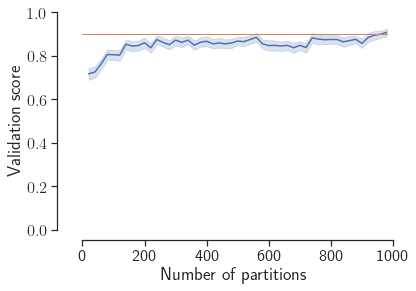

In [52]:
validation_data_df["score"] = (validation_data_df["n_validated"] / validation_data_df["n_validation"]).astype(float)
validation_data_df["n_partitions"] = validation_data_df["n_partitions"].astype(int)
sns.set(style="ticks", font_scale=1.5)
ax = sns.lineplot(x="n_partitions", y="score", markers=True, ci=95, data=validation_data_df)
ax.set(ylabel="Validation score", xlabel="Number of partitions", ylim=(0,1))
##plt.legend(loc=4)
plt.plot([0, validation_data_df["n_partitions"].max()], [accuracy, accuracy], '-', lw=1)
sns.despine(offset=10, trim=True);

plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
plt.savefig(f"results/validation_score_{networkname.split('.net')[0]}_d={distance_threshold}_a={accuracy}.png",
            bbox_inches="tight")

**Figure 1** The validation score as a function of number of partitions with bootstrapped 95% confidence intervals and given accuracy level.

# Compare partitions

### Find partitions (not necessary if already done above)

In [13]:
generatePartitions = False

if generatePartitions:
    partitions_df = pd.DataFrame() 
    niter = 100
    for i in range(niter):
        print(f"Iteration {i+1}")
        codelength = findCommunities(G, i)
        communities = list(nx.get_node_attributes(G, 'community').values())
        communities.insert(0, codelength)
        partitions_df = pd.concat([partitions_df, pd.DataFrame(communities,columns = [str(i)])], axis=1)

### Identify partition clusters

In [14]:
partitions_df.sort_values(by=0, axis=1,inplace=True)
codelengths = partitions_df.loc[0,:].to_numpy()
partitions_df.drop(0, axis=0,inplace=False).to_csv(r'results/partitions.csv',index=False,header=False,sep=' ')
!partition-validation/partition-validation -s 123 -t $distance_threshold results/partitions.csv results/partitions_clustering.txt    

Version: March 5, 2020.
Command: partition-validation/partition-validation -s 123 -t 0.3 results/partitions.csv results/partitions_clustering.txt
Setup:
-->Using seed: 123
-->Will cluster partitions such that no partition is farther away from its center than: 0.3
-->Will read partitions from file: results/partitions.csv
-->Will write clusters to file: results/partitions_clustering.txt
-->Will use number of threads: 1
Reading partitions file with 540 partitions...of 5603 nodes...done!
Clustering 540 partitions:
-->Writing 96 clusters...done!


### Read results and identify cluster sizes and cluster centers

#### Read partition clusters

In [15]:
# Only influde best maxclusters clusters
maxclusters = 20
partition_clusters_df = pd.read_csv('results/partitions_clustering.txt', delimiter=' ', comment='#')
Nclusters = partition_clusters_df['ClusterId'].max()
print(f"Solution landscape contains {Nclusters} clusters with {partition_clusters_df.shape[0]} partitions.")

if Nclusters > maxclusters:
    partition_clusters_df.drop(partition_clusters_df[partition_clusters_df.ClusterId > maxclusters].index, inplace=True)
    Nclusters = partition_clusters_df['ClusterId'].max()
    print(f"Including only the best {Nclusters} clusters with {partition_clusters_df.shape[0]} partitions.")

partition_clusters_df.head()

Solution landscape contains 96 clusters with 540 partitions.
Including only the best 20 clusters with 441 partitions.


ClusterId  PartitionId
0          1            1
1          1            2
2          1            3
3          1            4
4          1            5

#### Cluster sizes

In [16]:
clusterSizes = partition_clusters_df['ClusterId'].value_counts(sort=False)
maxClusterSize = max(clusterSizes)
solution_landscape_df = clusterSizes.to_frame().rename(columns={'ClusterId':'clustersize'})

#### Cluster centers and code lengths

In [17]:
Nclusters = partition_clusters_df['ClusterId'].max()
clusterCenters = np.empty(Nclusters)

for clusterId in range(1, Nclusters + 1):
    clusterCenters[clusterId - 1] = partition_clusters_df['PartitionId'][(partition_clusters_df['ClusterId'] == clusterId).idxmax()]

clusterCenters = clusterCenters.astype(int)
clusterCenterCodelengths = codelengths[clusterCenters - 1]
solution_landscape_df['partitionid'] = clusterCenters.tolist()
solution_landscape_df['codelength'] = clusterCenterCodelengths.tolist()

#### Read pairwise cluster center distances

In [18]:
distances_df = pd.read_csv('results/partitions_clustering_distances.txt', delimiter=' ', comment='#')
distances_df.drop(distances_df[(distances_df['ClusterId1'] > maxclusters) | (distances_df['ClusterId2'] > maxclusters)].index, inplace=True)
distances_df.head()

ClusterId1  ClusterId2  Distance
0           1           2  0.303393
1           1           3  0.304935
2           1           4  0.301480
3           1           5  0.309722
4           1           6  0.300479

#### Create partition distance matrix

Text(0.5, 1.0, 'Partition distance matrix')

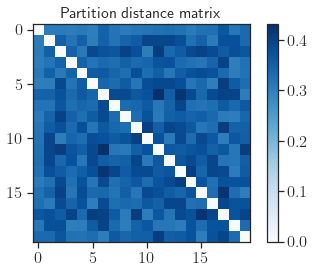

In [19]:
row = distances_df.to_numpy()[:,0].astype(int) - 1
col = distances_df.to_numpy()[:,1].astype(int) - 1
distances = distances_df.to_numpy()[:,2]
distance_matrix = np.zeros((Nclusters, Nclusters), dtype=distances.dtype)
distance_matrix[row, col] = distances
distance_matrix[col, row] = distances # Add transpose
plt.imshow(distance_matrix, zorder=2, cmap='Blues', interpolation='nearest')
plt.colorbar();
plt.title('Partition distance matrix', fontsize=16)

#### Identify coordinates in 2D with [Uniform Manifold Approximation and Projection (UMAP)](https://github.com/lmcinnes/umap)

In [26]:
U = umap.UMAP(metric='precomputed', n_neighbors=Nclusters - 1, min_dist=distance_threshold)
out = U.fit_transform(distance_matrix)
solution_landscape_df['xcoord'] = out[:, 0]
solution_landscape_df['ycoord'] = out[:, 1]
solution_landscape_df.head()

/opt/miniconda3/lib/python3.9/site-packages/umap/umap_.py:1735: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  warn(


clustersize  partitionid  codelength    xcoord     ycoord
1          268            1   10.093082  7.873838 -12.328211
2           38           24   10.101658  6.923088 -12.282611
3           12           36   10.104260  8.495911 -11.631730
4           14           46   10.106101  9.134772 -14.763161
5           16           64   10.107853  9.484289 -12.995202

#### Visualize solution landscape with contour plot

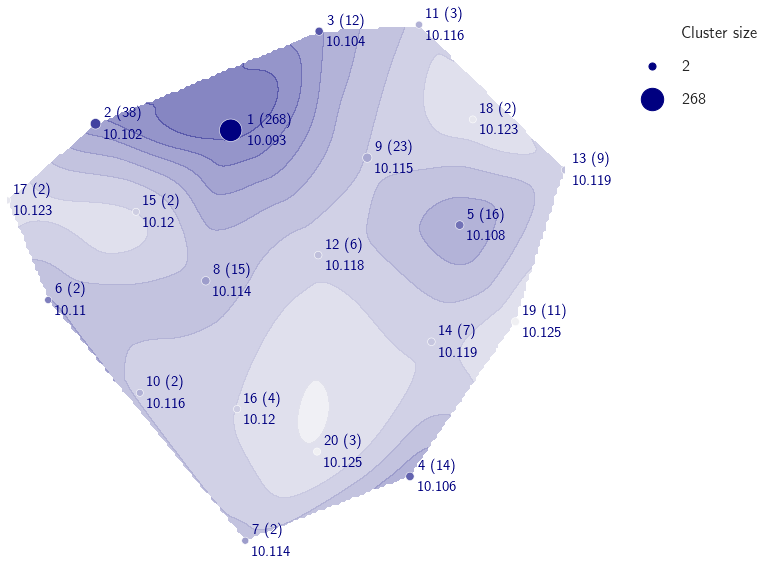

In [31]:
x = solution_landscape_df['xcoord'].values
y = solution_landscape_df['ycoord'].values
codelength = solution_landscape_df['codelength'].values

def plot_contour(x, y, codelength, resolution=200, contour_method='cubic'):
    resolution = f"{resolution}j"
    X, Y = np.mgrid[min(x):max(x):complex(resolution), min(y):max(y):complex(resolution)]
    points = list(zip(x, y))
    Z = griddata(points, codelength, (X, Y), method=contour_method)
    return X, Y, Z

X, Y, Z = plot_contour(x, y, codelength, resolution=200, contour_method='cubic')

palette = sns.light_palette("navy", reverse=True, as_cmap=True)
sns.set(style="whitegrid", font_scale=1.5)
f, ax = plt.subplots(figsize=(10, 10))
sns.despine(f, left=True, bottom=True)
p0 = ax.contourf(X, Y, Z, cmap=palette, alpha=0.5)
#cbaxes = f.add_axes([0.8, 0.1, 0.03, 0.8])
#cbar = f.colorbar(p0, cax=cbaxes)
p1 = sns.scatterplot(x="xcoord", y="ycoord", hue="codelength", size="clustersize",
            sizes=(50, 500), alpha=1, palette=palette, legend="full",
            data=solution_landscape_df)
plt.axis('equal')
# Commented out as it was throwing errors
#plt.title(f'Solution landscape of {networkname} with partition distance {distance_threshold} and accuracy {accuracy}')
plt.xlabel('')
#plt.xlabel('Embedded partition distance')
plt.ylabel('')
plt.xticks([])
plt.yticks([])
handles, labels = ax.get_legend_handles_labels()
for handle in handles[Nclusters + 1:]:
    handle.set_color(palette(0))
labels[Nclusters + 1] = 'Cluster size'
#handlestepsize = max(int((len(handles)-(Nclusters+1))/4),1)
plt.legend([handles[Nclusters + 1], handles[Nclusters + 2], handles[-1]],
           [labels[Nclusters + 1], labels[Nclusters + 2], labels[-1]],
           bbox_to_anchor=(1.1, 1), loc='upper left', frameon=False, ncol=1, labelspacing=1.1)

for clusterId in range(1, len(out) + 1):
    p1.text(solution_landscape_df['xcoord'].iloc[clusterId - 1] + 0.07 * solution_landscape_df['clustersize'].iloc[clusterId - 1] / maxClusterSize + 0.05,
            solution_landscape_df['ycoord'].iloc[clusterId - 1] - 0.1, 
            np.around(solution_landscape_df['codelength'].iloc[clusterId - 1], decimals=3),
            horizontalalignment='left', 
            size='small',
            color=palette(0),
            weight='semibold')
    p1.text(solution_landscape_df['xcoord'].iloc[clusterId - 1] + 0.07 *solution_landscape_df['clustersize'].iloc[clusterId - 1] / maxClusterSize + 0.05,
            solution_landscape_df['ycoord'].iloc[clusterId - 1] + 0.05,
            f"{clusterId} ({solution_landscape_df['clustersize'].iloc[clusterId - 1]})",
            horizontalalignment='left', 
            size='small',
            color=palette(0),
            weight='semibold')

plt.savefig(f"results/solution_landscape_{networkname.split('.net')[0]}_d={distance_threshold}_a={accuracy}.png",
            bbox_inches="tight")    


**Figure 2** Solution landscape. Circles represent partition clusters with size for the number of partitions in the cluster and color for the code length of the cluster center partition. Each cluster center is labeled by its number (ordered by increasing code length), the number of partitions it contains in parenthesis, and the code length of the cluster center partition. 

#### Print two best partitions in first and second cluster and visualize their differences
Can be analyzed and compared in https://www.mapequation.org/alluvial/

In [28]:
for clusterRank in range(1, 3):
    print(clusterRank)
    for partitionRank in range(1, 3):
        partitionId = partition_clusters_df[partition_clusters_df['ClusterId'] == clusterRank].iloc[partitionRank - 1][1]
        seed = int(partitions_df.columns[partitionId - 1])        
        printCommunities(network, seed, outfile=f"results/{networkname.split('.net')[0]}_cluster_{clusterRank}_partition_{partitionRank}.tree")

1
Find communities in pajek_influence_graph.net with Infomap...
Found 86 top modules with codelength: 10.093082444234335
Writing results to results/pajek_influence_graph_cluster_1_partition_1.tree
Find communities in pajek_influence_graph.net with Infomap...
Found 89 top modules with codelength: 10.09434642653855
Writing results to results/pajek_influence_graph_cluster_1_partition_2.tree
2
Find communities in pajek_influence_graph.net with Infomap...
Found 96 top modules with codelength: 10.101657604207787
Writing results to results/pajek_influence_graph_cluster_2_partition_1.tree
Find communities in pajek_influence_graph.net with Infomap...
Found 91 top modules with codelength: 10.104352128065482
Writing results to results/pajek_influence_graph_cluster_2_partition_2.tree


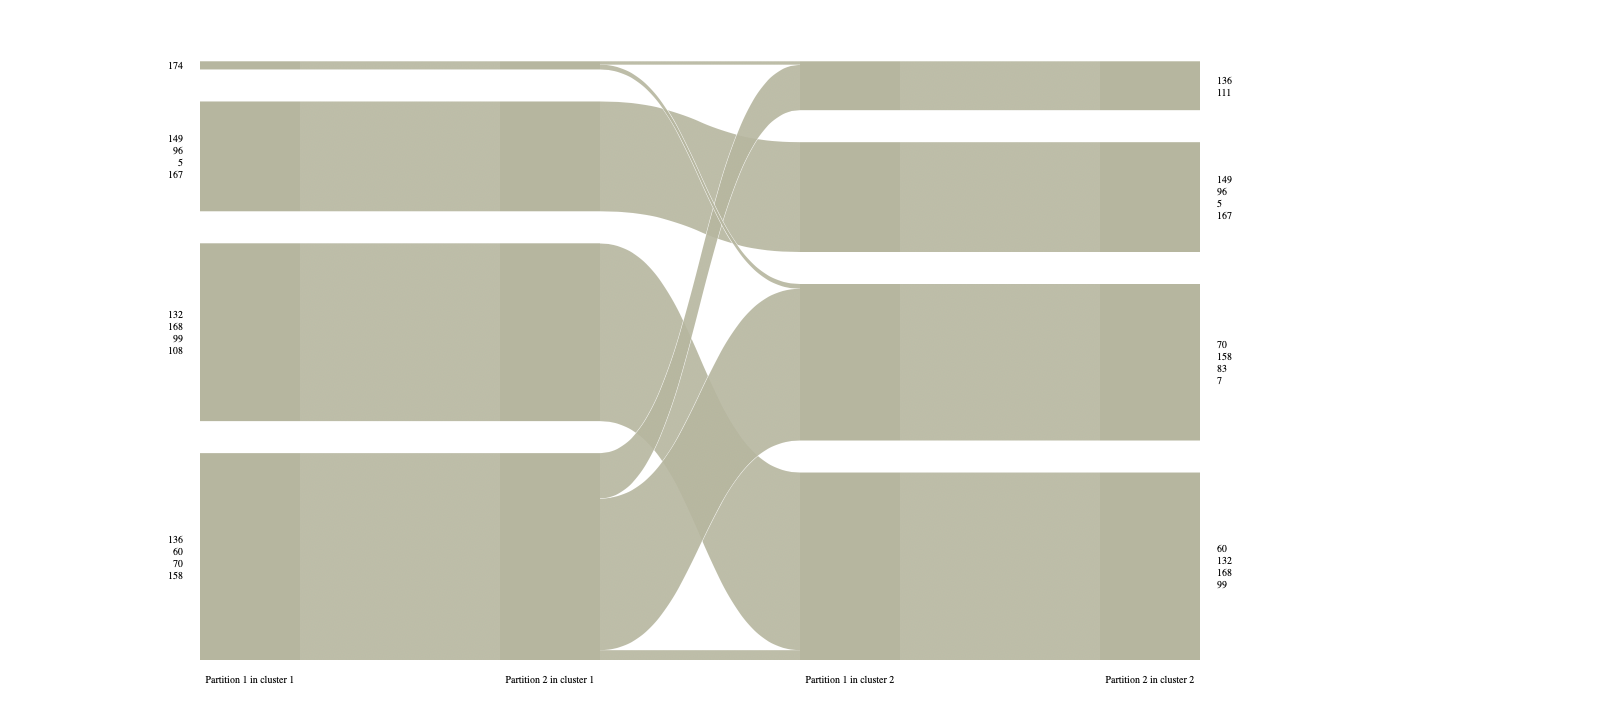

In [30]:
Image(filename='results/jazz_cluster_1-1-2-2_partition_1-2-1-2.png')

**Figure 3** Close-by cluster centers are more similar than distant cluster centers. The alluvial diagram shows top two partitions in cluster 1 and 2.